In [5]:
from __future__ import print_function
import pickle
# from sms import sendMessage
import os
import sys
import matplotlib.pyplot as plt
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from model import capsules
from loss import SpreadLoss
from torch import utils
from torch.utils.data import Dataset, TensorDataset, DataLoader
#########################
seed = 1
cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
#########################
image_size = 40
batch_size, test_batch_size =8, 8
init_lr = 3e-3 # moein - according to openreview
weight_decay = 2e-7  # moein - according to openreview
log_interval = 3
test_interval = 1
epochs = 200
snapshot_folder = 'belgium_weights_test'
test_code = True # moein - for checking the functions. If True, model will run one step.
log_test = False # moein - for getting logs
#########################

In [6]:
def get_setting(size= 20):
    train_data_dir = 'data\\belgium\\Training'
    test_data_dir = 'data\\belgium\\Testing'
    
#     train_data_dir = 'data\\germany_traffic\\Train'
#     test_data_dir = 'data\\germany_traffic\\Test'
    
    train_tfms = transforms.Compose([
                                     transforms.Resize((size, size)),
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.RandomRotation(10),
                                     transforms.ColorJitter(brightness=50/255, contrast=0.4),
#                                      transforms.RandomCrop(50),
                                     transforms.ToTensor()
                                 ])
    
    test_tfms = transforms.Compose([transforms.Resize((size, size)),
                                     transforms.Grayscale(num_output_channels=1),
#                                   transforms.CenterCrop(48),
                                transforms.ToTensor()
                                ])

    ############################################################################
    train_set = datasets.ImageFolder(train_data_dir,transform=train_tfms)
    test_set = datasets.ImageFolder(test_data_dir,transform=test_tfms)
    ############################################################################
    train_loader = DataLoader(train_set,batch_size = batch_size, shuffle=True, num_workers = 8)
    test_loader = DataLoader(test_set,batch_size = test_batch_size, shuffle=False, num_workers = 8)
    ############################################################################
    return train_loader, test_loader

In [7]:
train_loader, test_loader = get_setting(image_size)
num_class = len(train_loader.dataset.classes)
print(len(train_loader)*batch_size,len(test_loader)*test_batch_size,num_class)

4576 2520 62


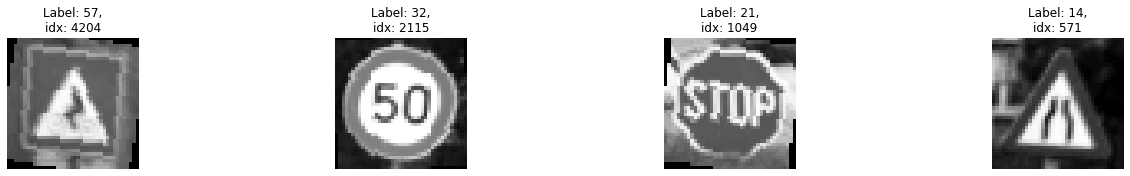

In [8]:
import random
def plot_gallery(imgs,image_size):
    plt.figure(figsize=(20,6))
    for idx in range(4) :
        if idx > 3 : break
        rand = random.randint(1,len(imgs))
        img_ = imgs[idx+rand][0]
        label = imgs[idx+rand][1]
        plt.subplot(1, 4, idx+1)
        plt.axis('off')
        plt.imshow(img_.reshape(image_size,image_size),cmap='Greys_r')
        plt.subplots_adjust(wspace=1.5)
        plt.title("Label: {0},\nidx: {1}".format(label,idx+rand))

plot_gallery(train_loader.dataset,image_size)

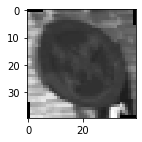

In [9]:
plt.figure(figsize=(2,2))

plt.imshow(train_loader.dataset[3242][0].reshape(image_size,image_size),cmap='Greys_r')
plt.show()

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs=0, ext_decay= 1):
    
    ''' * exponential learning rate decay added'''
    
    batch_time = AverageMeter()
    data_time = AverageMeter()

    model.train()
    train_len = len(train_loader)
    epoch_acc = 0
    i=0
    for batch_idx, (data, target) in enumerate(train_loader):
        i += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        r = (1.*batch_idx + (previous_epochs+epoch-1) * train_len) / ((previous_epochs+epochs)*train_len) # moein - used in criterion
        
        loss = criterion(output, target, r)        
        acc = accuracy(output, target)
        
        global_step = (batch_idx+1) + (previous_epochs + epoch - 1) * len(train_loader) # moein
        exp_lr_decay(optimizer = optimizer, global_step = global_step, ext_decay = ext_decay) # moein - change the learning rate exponentially
        
        if log_test:
            for param_group in optimizer.param_groups:
                print('optim lr:',param_group['lr'])
                print('step:',global_step)
        
        loss.backward()
        optimizer.step()
        epoch_acc += acc[0].item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\t'
                  'Loss: {:.6f}\tAccuracy: {:.6f}\t'.format(
                  epoch+previous_epochs, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item(), acc[0].item()))
            
        if test_code: return epoch_acc

    return epoch_acc

def test(test_loader, model, criterion, device):
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        i = 0
        for data, target in test_loader:
            progressBar(job='Test',value=i, endvalue=test_len); i += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, r=1).item()
            acc += accuracy(output, target)[0].item()
            
            if test_code: return acc

    test_loss /= test_len
    acc /= test_len
    print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))
    return acc


In [11]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def snapshot(model, folder, epoch, name):
    path = os.path.join(folder, 'model_{}_{}.pth'.format(name,epoch))
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    print('\nsaving model to {}'.format(path))
    torch.save(model.state_dict(), path)
    
def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,ext_decay = 1, staircase=False):
    
    ''' decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)  '''
    
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) * ext_decay
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) * ext_decay
    
#     lr = min(lr, lr_clip)

#     if global_step % decay_steps == 0:
#         print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [12]:
def mainTrain(name, epochs, model, history, optimizer, tolarance = 12, 
              previous_epochs = 0, best_acc= 0, init_decay_fac = 1,LR_decay_fac= 0.1 , best_epoch = 1):
    best_acc = best_acc
    best_epoch = best_epoch
    t, t1 = tolarance , tolarance
    noImp = 0
    decay_factor = init_decay_fac # moein - when training reaches the tolarance threshold, lr will be multiplied by this.
                                # inintial value of it is 1
    print('########### Training model {} ###########'.format(name))
    for epoch in range(1, epochs + 1):
        start=time.time()
        noImp = (epoch + previous_epochs) - best_epoch
        
        acc = train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs,ext_decay=decay_factor)
        acc /= len(train_loader)

        history['acc'].append(acc)        
        print('Epoch Train-Accuracy : {:.4f}'.format(acc))
                
        if epoch % test_interval == 0:
            test_acc = test(test_loader, model, criterion, device)
            history['val_acc'].append(test_acc)
            best_acc = max(best_acc,test_acc )
            
            
        snapshot(model, snapshot_folder, epoch+previous_epochs,name)
        
        end=time.time()
        for param_group in optimizer.param_groups:
            print('Current Learning Rate : {}'.format(param_group['lr']))
        
        
        if test_code == True: return best_acc
            
        if test_acc < best_acc:
            tolarance -= 1
            if tolarance < 0:
                print('{} epochs with no improvement since the multiplication. Multiplying LR by {}'.format(t,LR_decay_fac))
                t = t//2 + 1
                tolarance = t # moein - reset tolarence
                decay_factor *= LR_decay_fac 
        else :
            best_epoch = epoch + previous_epochs
            tolarance = t
            
        print('* Best val Accuracy so far : {:.3f} epoch : {} *'.format(best_acc,best_epoch))
        print('Total {} epochs with no improvement in val_acc.'.format(noImp))
        
        if noImp == t1*2 :
            print('Model has converged. Existing the training.')
            return best_acc
        
        print('Epoch time: {:.2f} mins'.format((end-start)/60))
        print('='*80)

    print('########### Training model {} finished ###########'.format(name))
    return best_acc

In [13]:
device = torch.device("cuda" if cuda else "cpu")
A, B, C, D = 64, 8, 16, 16
criterion = SpreadLoss(num_class=num_class, m_min=0.2, m_max=0.9)

------------------------------------------------------------------------------------

#### model 2 2 2

In [14]:
# model
torch.cuda.empty_cache()    
best_acc222 = 0
em_iters = [2,2,2]
model222 = capsules(A=A, B=B, C=C, D=D, E=num_class
                    ,iters_routings=em_iters
                   ).to(device)
history222={'val_acc':[],'acc':[]}
optimizer222 = optim.Adam(model222.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [2, 2, 2] 
stage output:  class_caps 
activation:  o


In [15]:
torch.cuda.empty_cache()
# model222.load_state_dict(torch.load('belgium_weights\\model_model222_A_55.pth'))
best_acc222= mainTrain('model222_A',epochs,model222,history222,optimizer222)

########### Training model model222_A ###########
at: tensor([[0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173,
         0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173,
         0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173,
         0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173,
         0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173,
         0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173,
         0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173, 0.6173],
        [0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176,
         0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176,
         0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176,
         0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176,
         0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.617

       device='cuda:0')

saving model to belgium_weights_test\model_model222_A_1.pth
Current Learning Rate : 0.002999993876707071


In [18]:
print('best test accuracy: {:.6f}'.format(best_acc222))
with open('model222_A_history.pkl','wb') as f:
    pickle.dump(history222,f)

best test accuracy: 92.130682


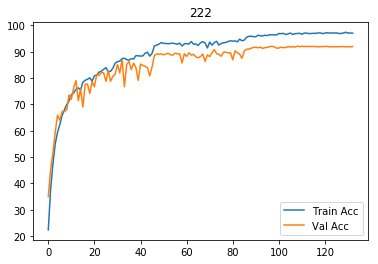

In [19]:
plt.title('222')
plt.plot(history222['acc'])
plt.plot(history222['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 91.99891596342388 epoch : 103

--------------------------------------------------------------------------------------------------

##### model 223
each epoch 16.5mins

In [14]:
# model
torch.cuda.empty_cache()    
best_acc223 = 0
em_iters = [2,2,3]
model223 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history223={'val_acc':[],'acc':[]}
optimizer223 = optim.Adam(model223.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [2, 2, 3] 
stage output:  class_caps 
activation:  o


In [26]:
# model223.load_state_dict(torch.load('caps_train_v3\\model_model223_A_122.pth'))
# history223['val_acc']=history223['val_acc'][:122]
# history223['acc']=history223['acc'][:122]

In [27]:
torch.cuda.empty_cache()    

best_acc223 = mainTrain('model223_A',epochs,model223,history223,
        optimizer223,tolarance=12,previous_epochs=0,best_acc=0, best_epoch = 1)

########### Training model model223_A ###########
Train Epoch: 1	[0/4575 (0%)]	Loss: 3.416177	Accuracy: 0.000000	
Train Epoch: 1	[800/4575 (17%)]	Loss: 2.516570	Accuracy: 9.375000	
Train Epoch: 1	[1600/4575 (35%)]	Loss: 1.921441	Accuracy: 3.125000	
Train Epoch: 1	[2400/4575 (52%)]	Loss: 2.036209	Accuracy: 6.250000	
Train Epoch: 1	[3200/4575 (70%)]	Loss: 1.073764	Accuracy: 21.875000	
Train Epoch: 1	[4000/4575 (87%)]	Loss: 1.680274	Accuracy: 9.375000	
Epoch Train-Accuracy : 12.8525
Test Completion: [------------------> ] 95%
Test set: Average loss: 38.606010, Accuracy: 18.512074 


saving model to belgium_weights\model_model223_A_1.pth
Current Learning Rate : 0.0029991244959936118
* Best val Accuracy so far : 18.512 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 2.45 mins
Train Epoch: 2	[0/4575 (0%)]	Loss: 1.052033	Accuracy: 21.875000	
Train Epoch: 2	[800/4575 (17%)]	Loss: 1.518040	Accuracy: 15.625000	
Train Epoch: 2	[1600/4575 (35%)]	Loss: 1.265767	Accuracy: 25.0

Train Epoch: 11	[0/4575 (0%)]	Loss: 0.322929	Accuracy: 78.125000	
Train Epoch: 11	[800/4575 (17%)]	Loss: 0.480497	Accuracy: 50.000000	
Train Epoch: 11	[1600/4575 (35%)]	Loss: 0.456580	Accuracy: 62.500000	
Train Epoch: 11	[2400/4575 (52%)]	Loss: 0.443197	Accuracy: 56.250000	
Train Epoch: 11	[3200/4575 (70%)]	Loss: 0.431272	Accuracy: 53.125000	
Train Epoch: 11	[4000/4575 (87%)]	Loss: 0.317652	Accuracy: 68.750000	
Epoch Train-Accuracy : 66.6641
Test Completion: [------------------> ] 95%
Test set: Average loss: 27.131077, Accuracy: 70.450994 


saving model to belgium_weights\model_model223_A_11.pth
Current Learning Rate : 0.002990383496266965
* Best val Accuracy so far : 70.451 epoch : 11 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.51 mins
Train Epoch: 12	[0/4575 (0%)]	Loss: 0.199495	Accuracy: 78.125000	
Train Epoch: 12	[800/4575 (17%)]	Loss: 0.218350	Accuracy: 65.625000	
Train Epoch: 12	[1600/4575 (35%)]	Loss: 0.207977	Accuracy: 71.875000	
Train Epoch: 12	[2400/4575 (

Train Epoch: 21	[0/4575 (0%)]	Loss: 0.418832	Accuracy: 84.375000	
Train Epoch: 21	[800/4575 (17%)]	Loss: 0.363576	Accuracy: 78.125000	
Train Epoch: 21	[1600/4575 (35%)]	Loss: 0.421098	Accuracy: 81.250000	
Train Epoch: 21	[2400/4575 (52%)]	Loss: 0.195320	Accuracy: 84.375000	
Train Epoch: 21	[3200/4575 (70%)]	Loss: 0.227570	Accuracy: 78.125000	
Train Epoch: 21	[4000/4575 (87%)]	Loss: 0.317816	Accuracy: 87.500000	
Epoch Train-Accuracy : 79.7830
Test Completion: [------------------> ] 95%
Test set: Average loss: 23.432336, Accuracy: 73.362926 


saving model to belgium_weights\model_model223_A_21.pth
Current Learning Rate : 0.0029816679723337785
* Best val Accuracy so far : 76.602 epoch : 17 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 2.50 mins
Train Epoch: 22	[0/4575 (0%)]	Loss: 0.321545	Accuracy: 75.000000	
Train Epoch: 22	[800/4575 (17%)]	Loss: 0.276682	Accuracy: 81.250000	
Train Epoch: 22	[1600/4575 (35%)]	Loss: 0.194020	Accuracy: 84.375000	
Train Epoch: 22	[2400/4575 

Train Epoch: 31	[0/4575 (0%)]	Loss: 0.183109	Accuracy: 81.250000	
Train Epoch: 31	[800/4575 (17%)]	Loss: 0.158271	Accuracy: 84.375000	
Train Epoch: 31	[1600/4575 (35%)]	Loss: 0.224594	Accuracy: 81.250000	
Train Epoch: 31	[2400/4575 (52%)]	Loss: 0.192651	Accuracy: 81.250000	
Train Epoch: 31	[3200/4575 (70%)]	Loss: 0.188785	Accuracy: 75.000000	
Train Epoch: 31	[4000/4575 (87%)]	Loss: 0.262369	Accuracy: 81.250000	
Epoch Train-Accuracy : 84.2608
Test Completion: [------------------> ] 95%
Test set: Average loss: 21.042043, Accuracy: 80.607244 


saving model to belgium_weights\model_model223_A_31.pth
Current Learning Rate : 0.0029729778499444155
* Best val Accuracy so far : 80.803 epoch : 27 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 2.50 mins
Train Epoch: 32	[0/4575 (0%)]	Loss: 0.205915	Accuracy: 84.375000	
Train Epoch: 32	[800/4575 (17%)]	Loss: 0.136160	Accuracy: 84.375000	
Train Epoch: 32	[1600/4575 (35%)]	Loss: 0.135328	Accuracy: 90.625000	
Train Epoch: 32	[2400/4575 

Train Epoch: 41	[0/4575 (0%)]	Loss: 0.188167	Accuracy: 93.750000	
Train Epoch: 41	[800/4575 (17%)]	Loss: 0.168028	Accuracy: 87.500000	
Train Epoch: 41	[1600/4575 (35%)]	Loss: 0.209290	Accuracy: 87.500000	
Train Epoch: 41	[2400/4575 (52%)]	Loss: 0.274127	Accuracy: 81.250000	
Train Epoch: 41	[3200/4575 (70%)]	Loss: 0.449190	Accuracy: 78.125000	
Train Epoch: 41	[4000/4575 (87%)]	Loss: 0.210748	Accuracy: 93.750000	
Epoch Train-Accuracy : 86.2093
Test Completion: [------------------> ] 95%
Test set: Average loss: 19.909521, Accuracy: 81.935369 


saving model to belgium_weights\model_model223_A_41.pth
Current Learning Rate : 0.0029643130550656414
* Best val Accuracy so far : 83.516 epoch : 34 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 2.48 mins
Train Epoch: 42	[0/4575 (0%)]	Loss: 0.299886	Accuracy: 84.375000	
Train Epoch: 42	[800/4575 (17%)]	Loss: 0.290327	Accuracy: 84.375000	
Train Epoch: 42	[1600/4575 (35%)]	Loss: 0.207156	Accuracy: 93.750000	
Train Epoch: 42	[2400/4575 

Train Epoch: 51	[0/4575 (0%)]	Loss: 0.646649	Accuracy: 81.250000	
Train Epoch: 51	[800/4575 (17%)]	Loss: 0.181512	Accuracy: 93.750000	
Train Epoch: 51	[1600/4575 (35%)]	Loss: 0.260266	Accuracy: 84.375000	
Train Epoch: 51	[2400/4575 (52%)]	Loss: 0.339440	Accuracy: 81.250000	
Train Epoch: 51	[3200/4575 (70%)]	Loss: 0.251122	Accuracy: 87.500000	
Train Epoch: 51	[4000/4575 (87%)]	Loss: 0.312837	Accuracy: 87.500000	
Epoch Train-Accuracy : 88.3925
Test Completion: [------------------> ] 95%
Test set: Average loss: 18.058312, Accuracy: 83.046875 


saving model to belgium_weights\model_model223_A_51.pth
Current Learning Rate : 0.0029556735138799935
* Best val Accuracy so far : 84.908 epoch : 49 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.48 mins
Train Epoch: 52	[0/4575 (0%)]	Loss: 0.208997	Accuracy: 84.375000	
Train Epoch: 52	[800/4575 (17%)]	Loss: 0.223972	Accuracy: 93.750000	
Train Epoch: 52	[1600/4575 (35%)]	Loss: 0.170809	Accuracy: 100.000000	
Train Epoch: 52	[2400/4575

Train Epoch: 61	[0/4575 (0%)]	Loss: 0.186366	Accuracy: 93.750000	
Train Epoch: 61	[800/4575 (17%)]	Loss: 0.148365	Accuracy: 84.375000	
Train Epoch: 61	[1600/4575 (35%)]	Loss: 0.202986	Accuracy: 93.750000	
Train Epoch: 61	[2400/4575 (52%)]	Loss: 0.141253	Accuracy: 96.875000	
Train Epoch: 61	[3200/4575 (70%)]	Loss: 0.205993	Accuracy: 100.000000	
Train Epoch: 61	[4000/4575 (87%)]	Loss: 0.167950	Accuracy: 93.750000	
Epoch Train-Accuracy : 91.3447
Test Completion: [------------------> ] 95%
Test set: Average loss: 16.602341, Accuracy: 85.216619 


saving model to belgium_weights\model_model223_A_61.pth
Current Learning Rate : 0.002947059152785149
* Best val Accuracy so far : 86.449 epoch : 60 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 2.49 mins
Train Epoch: 62	[0/4575 (0%)]	Loss: 0.629984	Accuracy: 81.250000	
Train Epoch: 62	[800/4575 (17%)]	Loss: 0.251161	Accuracy: 90.625000	
Train Epoch: 62	[1600/4575 (35%)]	Loss: 0.337017	Accuracy: 87.500000	
Train Epoch: 62	[2400/4575 

Train Epoch: 71	[0/4575 (0%)]	Loss: 0.219476	Accuracy: 84.375000	
Train Epoch: 71	[800/4575 (17%)]	Loss: 0.169851	Accuracy: 93.750000	
Train Epoch: 71	[1600/4575 (35%)]	Loss: 0.292973	Accuracy: 87.500000	
Train Epoch: 71	[2400/4575 (52%)]	Loss: 0.233811	Accuracy: 90.625000	
Train Epoch: 71	[3200/4575 (70%)]	Loss: 0.304780	Accuracy: 96.875000	
Train Epoch: 71	[4000/4575 (87%)]	Loss: 0.368564	Accuracy: 90.625000	
Epoch Train-Accuracy : 90.7307
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.655218, Accuracy: 85.039062 


saving model to belgium_weights\model_model223_A_71.pth
Current Learning Rate : 0.0029384698983933024
* Best val Accuracy so far : 86.879 epoch : 67 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 2.48 mins
Train Epoch: 72	[0/4575 (0%)]	Loss: 0.227096	Accuracy: 90.625000	
Train Epoch: 72	[800/4575 (17%)]	Loss: 0.220940	Accuracy: 93.750000	
Train Epoch: 72	[1600/4575 (35%)]	Loss: 0.228823	Accuracy: 93.750000	
Train Epoch: 72	[2400/4575 

Train Epoch: 81	[0/4575 (0%)]	Loss: 0.395634	Accuracy: 84.375000	
Train Epoch: 81	[800/4575 (17%)]	Loss: 0.234735	Accuracy: 100.000000	
Train Epoch: 81	[1600/4575 (35%)]	Loss: 0.209555	Accuracy: 100.000000	
Train Epoch: 81	[2400/4575 (52%)]	Loss: 0.218358	Accuracy: 96.875000	
Train Epoch: 81	[3200/4575 (70%)]	Loss: 0.832198	Accuracy: 84.375000	
Train Epoch: 81	[4000/4575 (87%)]	Loss: 0.222194	Accuracy: 96.875000	
Epoch Train-Accuracy : 92.5685
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.233805, Accuracy: 85.532671 


saving model to belgium_weights\model_model223_A_81.pth
Current Learning Rate : 0.0029299056775305386
* Best val Accuracy so far : 88.810 epoch : 79 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.49 mins
Train Epoch: 82	[0/4575 (0%)]	Loss: 0.281027	Accuracy: 90.625000	
Train Epoch: 82	[800/4575 (17%)]	Loss: 0.249122	Accuracy: 96.875000	
Train Epoch: 82	[1600/4575 (35%)]	Loss: 0.309549	Accuracy: 93.750000	
Train Epoch: 82	[2400/457

Train Epoch: 91	[0/4575 (0%)]	Loss: 0.217001	Accuracy: 100.000000	
Train Epoch: 91	[800/4575 (17%)]	Loss: 0.284054	Accuracy: 100.000000	
Train Epoch: 91	[1600/4575 (35%)]	Loss: 0.606528	Accuracy: 87.500000	
Train Epoch: 91	[2400/4575 (52%)]	Loss: 0.222841	Accuracy: 93.750000	
Train Epoch: 91	[3200/4575 (70%)]	Loss: 0.294226	Accuracy: 96.875000	
Train Epoch: 91	[4000/4575 (87%)]	Loss: 0.415379	Accuracy: 90.625000	
Epoch Train-Accuracy : 93.7479
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.557834, Accuracy: 88.966619 


saving model to belgium_weights\model_model223_A_91.pth
Current Learning Rate : 0.0029213664172362073
* Best val Accuracy so far : 89.062 epoch : 90 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 2.43 mins
Train Epoch: 92	[0/4575 (0%)]	Loss: 0.307274	Accuracy: 84.375000	
Train Epoch: 92	[800/4575 (17%)]	Loss: 0.323817	Accuracy: 93.750000	
Train Epoch: 92	[1600/4575 (35%)]	Loss: 0.629928	Accuracy: 93.750000	
Train Epoch: 92	[2400/457

Train Epoch: 101	[0/4575 (0%)]	Loss: 0.458253	Accuracy: 96.875000	
Train Epoch: 101	[800/4575 (17%)]	Loss: 0.545713	Accuracy: 93.750000	
Train Epoch: 101	[1600/4575 (35%)]	Loss: 0.618568	Accuracy: 87.500000	
Train Epoch: 101	[2400/4575 (52%)]	Loss: 0.583018	Accuracy: 84.375000	
Train Epoch: 101	[3200/4575 (70%)]	Loss: 0.536632	Accuracy: 96.875000	
Train Epoch: 101	[4000/4575 (87%)]	Loss: 0.372832	Accuracy: 100.000000	
Epoch Train-Accuracy : 93.7021
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.251696, Accuracy: 88.497869 


saving model to belgium_weights\model_model223_A_101.pth
Current Learning Rate : 0.002912852044762304
* Best val Accuracy so far : 91.001 epoch : 100 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 2.47 mins
Train Epoch: 102	[0/4575 (0%)]	Loss: 0.523078	Accuracy: 93.750000	
Train Epoch: 102	[800/4575 (17%)]	Loss: 0.581831	Accuracy: 96.875000	
Train Epoch: 102	[1600/4575 (35%)]	Loss: 0.525515	Accuracy: 93.750000	
Train Epoch: 102

Train Epoch: 120	[0/4575 (0%)]	Loss: 1.009285	Accuracy: 96.875000	
Train Epoch: 120	[800/4575 (17%)]	Loss: 0.974393	Accuracy: 96.875000	
Train Epoch: 120	[1600/4575 (35%)]	Loss: 0.991581	Accuracy: 100.000000	
Train Epoch: 120	[2400/4575 (52%)]	Loss: 0.974399	Accuracy: 96.875000	
Train Epoch: 120	[3200/4575 (70%)]	Loss: 1.022244	Accuracy: 100.000000	
Train Epoch: 120	[4000/4575 (87%)]	Loss: 1.042075	Accuracy: 100.000000	
Epoch Train-Accuracy : 96.4584
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.209340, Accuracy: 92.013494 


saving model to belgium_weights\model_model223_A_120.pth
Current Learning Rate : 0.00028967430433899294
* Best val Accuracy so far : 92.013 epoch : 120 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 2.46 mins
Train Epoch: 121	[0/4575 (0%)]	Loss: 1.256852	Accuracy: 96.875000	
Train Epoch: 121	[800/4575 (17%)]	Loss: 1.062597	Accuracy: 96.875000	
Train Epoch: 121	[1600/4575 (35%)]	Loss: 1.525724	Accuracy: 93.750000	
Train Epoch:

Train Epoch: 139	[800/4575 (17%)]	Loss: 2.143712	Accuracy: 90.625000	
Train Epoch: 139	[1600/4575 (35%)]	Loss: 2.027702	Accuracy: 100.000000	
Train Epoch: 139	[2400/4575 (52%)]	Loss: 2.137855	Accuracy: 93.750000	
Train Epoch: 139	[3200/4575 (70%)]	Loss: 2.178980	Accuracy: 90.625000	
Train Epoch: 139	[4000/4575 (87%)]	Loss: 2.353135	Accuracy: 90.625000	
Epoch Train-Accuracy : 97.0054
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.201080, Accuracy: 91.370739 


saving model to belgium_weights\model_model223_A_139.pth
Current Learning Rate : 0.0002880723129935934
* Best val Accuracy so far : 92.209 epoch : 135 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 2.47 mins
Train Epoch: 140	[0/4575 (0%)]	Loss: 2.167896	Accuracy: 96.875000	
Train Epoch: 140	[800/4575 (17%)]	Loss: 2.096799	Accuracy: 96.875000	
Train Epoch: 140	[1600/4575 (35%)]	Loss: 2.192152	Accuracy: 100.000000	
Train Epoch: 140	[2400/4575 (52%)]	Loss: 2.181117	Accuracy: 100.000000	
Train Epo

Train Epoch: 149	[0/4575 (0%)]	Loss: 2.943859	Accuracy: 96.875000	
Train Epoch: 149	[800/4575 (17%)]	Loss: 2.815703	Accuracy: 100.000000	
Train Epoch: 149	[1600/4575 (35%)]	Loss: 2.937064	Accuracy: 96.875000	
Train Epoch: 149	[2400/4575 (52%)]	Loss: 3.154056	Accuracy: 96.875000	
Train Epoch: 149	[3200/4575 (70%)]	Loss: 2.871692	Accuracy: 100.000000	
Train Epoch: 149	[4000/4575 (87%)]	Loss: 3.494187	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.9187
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.974597, Accuracy: 91.857244 


saving model to belgium_weights\model_model223_A_149.pth
Current Learning Rate : 2.8723272130191966e-05
* Best val Accuracy so far : 92.287 epoch : 140 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 2.47 mins
Train Epoch: 150	[0/4575 (0%)]	Loss: 3.247730	Accuracy: 90.625000	
Train Epoch: 150	[800/4575 (17%)]	Loss: 2.957687	Accuracy: 100.000000	
Train Epoch: 150	[1600/4575 (35%)]	Loss: 3.024990	Accuracy: 100.000000	
Train Epoch

Train Epoch: 158	[4000/4575 (87%)]	Loss: 4.030982	Accuracy: 100.000000	
Epoch Train-Accuracy : 96.9836
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.959213, Accuracy: 91.779119 


saving model to belgium_weights\model_model223_A_158.pth
Current Learning Rate : 2.8647918117157e-07
* Best val Accuracy so far : 92.287 epoch : 140 *
Total 18 epochs with no improvement in val_acc.
Epoch time: 2.47 mins
Train Epoch: 159	[0/4575 (0%)]	Loss: 3.953504	Accuracy: 96.875000	
Train Epoch: 159	[800/4575 (17%)]	Loss: 4.003035	Accuracy: 96.875000	
Train Epoch: 159	[1600/4575 (35%)]	Loss: 4.770016	Accuracy: 96.875000	
Train Epoch: 159	[2400/4575 (52%)]	Loss: 3.892543	Accuracy: 100.000000	
Train Epoch: 159	[3200/4575 (70%)]	Loss: 3.850958	Accuracy: 96.875000	
Train Epoch: 159	[4000/4575 (87%)]	Loss: 4.138271	Accuracy: 96.875000	
Epoch Train-Accuracy : 97.1577
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.961574, Accuracy: 91.740057 


saving model to bel

In [28]:
with open('model223_A_history.pkl','wb') as f:
    pickle.dump(history223,f)
print('best test accuracy: {:.6f}'.format(best_acc223))

best test accuracy: 92.286932


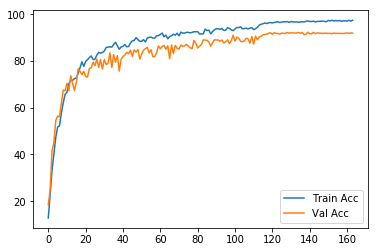

In [29]:
plt.plot(history223['acc'])
plt.plot(history223['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

In [25]:
# with open('model223_A_history.pkl','rb') as f:
#     history223=pickle.load(f)

=====================================================
#### model 221

In [15]:
# model
torch.cuda.empty_cache()    
best_acc221 = 0
em_iters = [2,2,1]
model221 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history221={'val_acc':[],'acc':[]}
optimizer221 = optim.Adam(model221.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [2, 2, 1] 
stage output:  class_caps 
activation:  o


In [23]:
model221.load_state_dict(torch.load('belgium_weights\\model_model221_A_11.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
torch.cuda.empty_cache()    

best_acc221 = mainTrain('model221_A',epochs,model221,history221,optimizer221,tolarance=20, previous_epochs=11,
                        best_epoch=4,best_acc=31.296)

########### Training model model221_A ###########
Train Epoch: 12	[0/4575 (0%)]	Loss: 3.402167	Accuracy: 6.250000	
Train Epoch: 12	[800/4575 (17%)]	Loss: 3.254937	Accuracy: 6.250000	
Train Epoch: 12	[1600/4575 (35%)]	Loss: 3.104747	Accuracy: 6.250000	
Train Epoch: 12	[2400/4575 (52%)]	Loss: 2.947500	Accuracy: 9.375000	
Train Epoch: 12	[3200/4575 (70%)]	Loss: 2.418588	Accuracy: 0.000000	
Train Epoch: 12	[4000/4575 (87%)]	Loss: 2.517289	Accuracy: 12.500000	
Epoch Train-Accuracy : 7.6712
Test Completion: [------------------> ] 95%
Test set: Average loss: 43.496423, Accuracy: 5.607244 


saving model to belgium_weights\model_model221_A_12.pth
Current Learning Rate : 0.0029895107986897588
* Best val Accuracy so far : 31.296 epoch : 4 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 13	[0/4575 (0%)]	Loss: 1.987946	Accuracy: 15.625000	
Train Epoch: 13	[800/4575 (17%)]	Loss: 2.349689	Accuracy: 9.375000	
Train Epoch: 13	[1600/4575 (35%)]	Loss: 1.894832	Accurac

Train Epoch: 22	[0/4575 (0%)]	Loss: 1.983400	Accuracy: 31.250000	
Train Epoch: 22	[800/4575 (17%)]	Loss: 2.221313	Accuracy: 21.875000	
Train Epoch: 22	[1600/4575 (35%)]	Loss: 1.631650	Accuracy: 37.500000	
Train Epoch: 22	[2400/4575 (52%)]	Loss: 2.788339	Accuracy: 18.750000	
Train Epoch: 22	[3200/4575 (70%)]	Loss: 2.379730	Accuracy: 15.625000	
Train Epoch: 22	[4000/4575 (87%)]	Loss: 1.713431	Accuracy: 25.000000	
Epoch Train-Accuracy : 24.4353
Test Completion: [------------------> ] 95%
Test set: Average loss: 36.187643, Accuracy: 29.112216 


saving model to belgium_weights\model_model221_A_22.pth
Current Learning Rate : 0.002980797818248613
* Best val Accuracy so far : 31.296 epoch : 4 *
Total 18 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 23	[0/4575 (0%)]	Loss: 1.776019	Accuracy: 12.500000	
Train Epoch: 23	[800/4575 (17%)]	Loss: 1.399084	Accuracy: 40.625000	
Train Epoch: 23	[1600/4575 (35%)]	Loss: 1.507676	Accuracy: 25.000000	
Train Epoch: 23	[2400/4575 (

Train Epoch: 32	[0/4575 (0%)]	Loss: 2.258499	Accuracy: 28.125000	
Train Epoch: 32	[800/4575 (17%)]	Loss: 2.024567	Accuracy: 43.750000	
Train Epoch: 32	[1600/4575 (35%)]	Loss: 1.606293	Accuracy: 25.000000	
Train Epoch: 32	[2400/4575 (52%)]	Loss: 1.499259	Accuracy: 34.375000	
Train Epoch: 32	[3200/4575 (70%)]	Loss: 1.568346	Accuracy: 40.625000	
Train Epoch: 32	[4000/4575 (87%)]	Loss: 2.294671	Accuracy: 31.250000	
Epoch Train-Accuracy : 35.8081
Test Completion: [------------------> ] 95%
Test set: Average loss: 31.859811, Accuracy: 37.027699 


saving model to belgium_weights\model_model221_A_32.pth
Current Learning Rate : 0.0029721102319382386
* Best val Accuracy so far : 37.457 epoch : 31 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 33	[0/4575 (0%)]	Loss: 1.712995	Accuracy: 43.750000	
Train Epoch: 33	[800/4575 (17%)]	Loss: 1.584969	Accuracy: 34.375000	
Train Epoch: 33	[1600/4575 (35%)]	Loss: 1.820657	Accuracy: 37.500000	
Train Epoch: 33	[2400/4575 

Train Epoch: 42	[0/4575 (0%)]	Loss: 1.907311	Accuracy: 46.875000	
Train Epoch: 42	[800/4575 (17%)]	Loss: 1.387125	Accuracy: 53.125000	
Train Epoch: 42	[1600/4575 (35%)]	Loss: 1.905554	Accuracy: 46.875000	
Train Epoch: 42	[2400/4575 (52%)]	Loss: 2.436922	Accuracy: 40.625000	
Train Epoch: 42	[3200/4575 (70%)]	Loss: 1.887523	Accuracy: 31.250000	
Train Epoch: 42	[4000/4575 (87%)]	Loss: 2.194249	Accuracy: 31.250000	
Epoch Train-Accuracy : 41.8601
Test Completion: [------------------> ] 95%
Test set: Average loss: 28.160644, Accuracy: 43.998579 


saving model to belgium_weights\model_model221_A_42.pth
Current Learning Rate : 0.0029634479657470085
* Best val Accuracy so far : 43.999 epoch : 42 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 43	[0/4575 (0%)]	Loss: 1.076282	Accuracy: 46.875000	
Train Epoch: 43	[800/4575 (17%)]	Loss: 1.288833	Accuracy: 46.875000	
Train Epoch: 43	[1600/4575 (35%)]	Loss: 1.802215	Accuracy: 34.375000	
Train Epoch: 43	[2400/4575 

Train Epoch: 52	[0/4575 (0%)]	Loss: 2.203787	Accuracy: 46.875000	
Train Epoch: 52	[800/4575 (17%)]	Loss: 1.642555	Accuracy: 37.500000	
Train Epoch: 52	[1600/4575 (35%)]	Loss: 1.423454	Accuracy: 50.000000	
Train Epoch: 52	[2400/4575 (52%)]	Loss: 1.833236	Accuracy: 56.250000	
Train Epoch: 52	[3200/4575 (70%)]	Loss: 2.146201	Accuracy: 37.500000	
Train Epoch: 52	[4000/4575 (87%)]	Loss: 1.609390	Accuracy: 56.250000	
Epoch Train-Accuracy : 46.9102
Test Completion: [------------------> ] 95%
Test set: Average loss: 25.640827, Accuracy: 46.789773 


saving model to belgium_weights\model_model221_A_52.pth
Current Learning Rate : 0.0029548109458790005
* Best val Accuracy so far : 46.790 epoch : 52 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 53	[0/4575 (0%)]	Loss: 1.861486	Accuracy: 40.625000	
Train Epoch: 53	[800/4575 (17%)]	Loss: 2.459507	Accuracy: 37.500000	
Train Epoch: 53	[1600/4575 (35%)]	Loss: 2.276877	Accuracy: 37.500000	
Train Epoch: 53	[2400/4575 

Train Epoch: 62	[0/4575 (0%)]	Loss: 1.812000	Accuracy: 56.250000	
Train Epoch: 62	[800/4575 (17%)]	Loss: 1.044249	Accuracy: 62.500000	
Train Epoch: 62	[1600/4575 (35%)]	Loss: 1.799203	Accuracy: 59.375000	
Train Epoch: 62	[2400/4575 (52%)]	Loss: 1.828098	Accuracy: 46.875000	
Train Epoch: 62	[3200/4575 (70%)]	Loss: 2.118205	Accuracy: 53.125000	
Train Epoch: 62	[4000/4575 (87%)]	Loss: 2.659780	Accuracy: 40.625000	
Epoch Train-Accuracy : 49.4600
Test Completion: [------------------> ] 95%
Test set: Average loss: 24.627564, Accuracy: 46.658381 


saving model to belgium_weights\model_model221_A_62.pth
Current Learning Rate : 0.002946199098753373
* Best val Accuracy so far : 49.524 epoch : 60 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 63	[0/4575 (0%)]	Loss: 2.126081	Accuracy: 40.625000	
Train Epoch: 63	[800/4575 (17%)]	Loss: 2.067020	Accuracy: 40.625000	
Train Epoch: 63	[1600/4575 (35%)]	Loss: 2.855019	Accuracy: 43.750000	
Train Epoch: 63	[2400/4575 (

Train Epoch: 72	[0/4575 (0%)]	Loss: 2.591972	Accuracy: 46.875000	
Train Epoch: 72	[800/4575 (17%)]	Loss: 1.838311	Accuracy: 62.500000	
Train Epoch: 72	[1600/4575 (35%)]	Loss: 2.356089	Accuracy: 59.375000	
Train Epoch: 72	[2400/4575 (52%)]	Loss: 2.242162	Accuracy: 56.250000	
Train Epoch: 72	[3200/4575 (70%)]	Loss: 2.620295	Accuracy: 43.750000	
Train Epoch: 72	[4000/4575 (87%)]	Loss: 2.400639	Accuracy: 62.500000	
Epoch Train-Accuracy : 53.4422
Test Completion: [------------------> ] 95%
Test set: Average loss: 22.673394, Accuracy: 49.144176 


saving model to belgium_weights\model_model221_A_72.pth
Current Learning Rate : 0.002937612351003738
* Best val Accuracy so far : 52.649 epoch : 66 *
Total 6 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 73	[0/4575 (0%)]	Loss: 2.379089	Accuracy: 43.750000	
Train Epoch: 73	[800/4575 (17%)]	Loss: 2.074936	Accuracy: 53.125000	
Train Epoch: 73	[1600/4575 (35%)]	Loss: 2.952340	Accuracy: 40.625000	
Train Epoch: 73	[2400/4575 (

Train Epoch: 82	[0/4575 (0%)]	Loss: 2.253050	Accuracy: 56.250000	
Train Epoch: 82	[800/4575 (17%)]	Loss: 2.574259	Accuracy: 68.750000	
Train Epoch: 82	[1600/4575 (35%)]	Loss: 2.136175	Accuracy: 62.500000	
Train Epoch: 82	[2400/4575 (52%)]	Loss: 2.725197	Accuracy: 50.000000	
Train Epoch: 82	[3200/4575 (70%)]	Loss: 2.368614	Accuracy: 62.500000	
Train Epoch: 82	[4000/4575 (87%)]	Loss: 2.600124	Accuracy: 62.500000	
Epoch Train-Accuracy : 55.0128
Test Completion: [------------------> ] 95%
Test set: Average loss: 22.401113, Accuracy: 51.022727 


saving model to belgium_weights\model_model221_A_82.pth
Current Learning Rate : 0.0029290506294775325
* Best val Accuracy so far : 54.268 epoch : 75 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 83	[0/4575 (0%)]	Loss: 2.457574	Accuracy: 53.125000	
Train Epoch: 83	[800/4575 (17%)]	Loss: 2.751806	Accuracy: 53.125000	
Train Epoch: 83	[1600/4575 (35%)]	Loss: 2.874882	Accuracy: 50.000000	
Train Epoch: 83	[2400/4575 

Train Epoch: 92	[0/4575 (0%)]	Loss: 4.014801	Accuracy: 53.125000	
Train Epoch: 92	[800/4575 (17%)]	Loss: 3.677377	Accuracy: 59.375000	
Train Epoch: 92	[1600/4575 (35%)]	Loss: 3.325159	Accuracy: 46.875000	
Train Epoch: 92	[2400/4575 (52%)]	Loss: 2.496850	Accuracy: 65.625000	
Train Epoch: 92	[3200/4575 (70%)]	Loss: 3.956716	Accuracy: 46.875000	
Train Epoch: 92	[4000/4575 (87%)]	Loss: 2.965697	Accuracy: 56.250000	
Epoch Train-Accuracy : 56.4819
Test Completion: [------------------> ] 95%
Test set: Average loss: 20.858952, Accuracy: 55.010653 


saving model to belgium_weights\model_model221_A_92.pth
Current Learning Rate : 0.002920513861235401
* Best val Accuracy so far : 55.639 epoch : 90 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 93	[0/4575 (0%)]	Loss: 3.017033	Accuracy: 59.375000	
Train Epoch: 93	[800/4575 (17%)]	Loss: 4.265535	Accuracy: 43.750000	
Train Epoch: 93	[1600/4575 (35%)]	Loss: 3.024981	Accuracy: 71.875000	
Train Epoch: 93	[2400/4575 (

Train Epoch: 102	[0/4575 (0%)]	Loss: 4.225837	Accuracy: 46.875000	
Train Epoch: 102	[800/4575 (17%)]	Loss: 3.127914	Accuracy: 62.500000	
Train Epoch: 102	[1600/4575 (35%)]	Loss: 2.920412	Accuracy: 56.250000	
Train Epoch: 102	[2400/4575 (52%)]	Loss: 3.726308	Accuracy: 53.125000	
Train Epoch: 102	[3200/4575 (70%)]	Loss: 3.161830	Accuracy: 53.125000	
Train Epoch: 102	[4000/4575 (87%)]	Loss: 4.018707	Accuracy: 46.875000	
Epoch Train-Accuracy : 57.7473
Test Completion: [------------------> ] 95%
Test set: Average loss: 19.921655, Accuracy: 56.903409 


saving model to belgium_weights\model_model221_A_102.pth
Current Learning Rate : 0.0029120019735505687
* Best val Accuracy so far : 56.903 epoch : 102 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 103	[0/4575 (0%)]	Loss: 2.407305	Accuracy: 71.875000	
Train Epoch: 103	[800/4575 (17%)]	Loss: 4.679007	Accuracy: 37.500000	
Train Epoch: 103	[1600/4575 (35%)]	Loss: 2.484958	Accuracy: 71.875000	
Train Epoch: 103

Train Epoch: 121	[1600/4575 (35%)]	Loss: 4.542928	Accuracy: 53.125000	
Train Epoch: 121	[2400/4575 (52%)]	Loss: 4.319221	Accuracy: 59.375000	
Train Epoch: 121	[3200/4575 (70%)]	Loss: 3.274134	Accuracy: 62.500000	
Train Epoch: 121	[4000/4575 (87%)]	Loss: 4.939113	Accuracy: 59.375000	
Epoch Train-Accuracy : 58.6228
Test Completion: [------------------> ] 95%
Test set: Average loss: 18.999471, Accuracy: 53.210227 


saving model to belgium_weights\model_model221_A_121.pth
Current Learning Rate : 0.002895897673343274
* Best val Accuracy so far : 57.908 epoch : 114 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 122	[0/4575 (0%)]	Loss: 3.971840	Accuracy: 68.750000	
Train Epoch: 122	[800/4575 (17%)]	Loss: 3.747998	Accuracy: 68.750000	
Train Epoch: 122	[1600/4575 (35%)]	Loss: 4.897457	Accuracy: 43.750000	
Train Epoch: 122	[2400/4575 (52%)]	Loss: 4.433505	Accuracy: 56.250000	
Train Epoch: 122	[3200/4575 (70%)]	Loss: 4.748487	Accuracy: 50.000000	
Train Epoch:

Train Epoch: 131	[0/4575 (0%)]	Loss: 6.432117	Accuracy: 62.500000	
Train Epoch: 131	[800/4575 (17%)]	Loss: 6.702127	Accuracy: 43.750000	
Train Epoch: 131	[1600/4575 (35%)]	Loss: 5.532941	Accuracy: 62.500000	
Train Epoch: 131	[2400/4575 (52%)]	Loss: 4.396072	Accuracy: 68.750000	
Train Epoch: 131	[3200/4575 (70%)]	Loss: 4.501517	Accuracy: 50.000000	
Train Epoch: 131	[4000/4575 (87%)]	Loss: 4.616802	Accuracy: 68.750000	
Epoch Train-Accuracy : 57.5964
Test Completion: [------------------> ] 95%
Test set: Average loss: 18.312656, Accuracy: 53.661222 


saving model to belgium_weights\model_model221_A_131.pth
Current Learning Rate : 0.002887457529959795
* Best val Accuracy so far : 57.908 epoch : 114 *
Total 17 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 132	[0/4575 (0%)]	Loss: 5.615885	Accuracy: 43.750000	
Train Epoch: 132	[800/4575 (17%)]	Loss: 4.951775	Accuracy: 68.750000	
Train Epoch: 132	[1600/4575 (35%)]	Loss: 6.563207	Accuracy: 50.000000	
Train Epoch: 132

Epoch Train-Accuracy : 60.8977
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.504314, Accuracy: 56.747159 


saving model to belgium_weights\model_model221_A_140.pth
Current Learning Rate : 0.0002879882435055416
* Best val Accuracy so far : 58.835 epoch : 139 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 141	[0/4575 (0%)]	Loss: 4.178854	Accuracy: 71.875000	
Train Epoch: 141	[800/4575 (17%)]	Loss: 5.253359	Accuracy: 50.000000	
Train Epoch: 141	[1600/4575 (35%)]	Loss: 4.928700	Accuracy: 50.000000	
Train Epoch: 141	[2400/4575 (52%)]	Loss: 4.912072	Accuracy: 43.750000	
Train Epoch: 141	[3200/4575 (70%)]	Loss: 3.463338	Accuracy: 78.125000	
Train Epoch: 141	[4000/4575 (87%)]	Loss: 4.673014	Accuracy: 56.250000	
Epoch Train-Accuracy : 61.0069
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.251542, Accuracy: 58.955966 


saving model to belgium_weights\model_model221_A_141.pth
Current Learning Rate : 0.00028790

Train Epoch: 150	[800/4575 (17%)]	Loss: 4.751715	Accuracy: 62.500000	
Train Epoch: 150	[1600/4575 (35%)]	Loss: 5.880706	Accuracy: 59.375000	
Train Epoch: 150	[2400/4575 (52%)]	Loss: 4.318123	Accuracy: 56.250000	
Train Epoch: 150	[3200/4575 (70%)]	Loss: 5.172112	Accuracy: 59.375000	
Train Epoch: 150	[4000/4575 (87%)]	Loss: 5.448112	Accuracy: 62.500000	
Epoch Train-Accuracy : 61.6407
Test Completion: [------------------> ] 95%
Test set: Average loss: 14.907116, Accuracy: 58.316761 


saving model to belgium_weights\model_model221_A_150.pth
Current Learning Rate : 0.0002871488968358311
* Best val Accuracy so far : 59.677 epoch : 148 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 151	[0/4575 (0%)]	Loss: 5.709762	Accuracy: 59.375000	
Train Epoch: 151	[800/4575 (17%)]	Loss: 5.289224	Accuracy: 59.375000	
Train Epoch: 151	[1600/4575 (35%)]	Loss: 5.042474	Accuracy: 56.250000	
Train Epoch: 151	[2400/4575 (52%)]	Loss: 5.370216	Accuracy: 50.000000	
Train Epoch:

Train Epoch: 160	[0/4575 (0%)]	Loss: 5.637117	Accuracy: 62.500000	
Train Epoch: 160	[800/4575 (17%)]	Loss: 4.530898	Accuracy: 62.500000	
Train Epoch: 160	[1600/4575 (35%)]	Loss: 6.585903	Accuracy: 56.250000	
Train Epoch: 160	[2400/4575 (52%)]	Loss: 6.447008	Accuracy: 65.625000	
Train Epoch: 160	[3200/4575 (70%)]	Loss: 5.665964	Accuracy: 68.750000	
Train Epoch: 160	[4000/4575 (87%)]	Loss: 8.228889	Accuracy: 59.375000	
Epoch Train-Accuracy : 62.2272
Test Completion: [------------------> ] 95%
Test set: Average loss: 14.741117, Accuracy: 57.357954 


saving model to belgium_weights\model_model221_A_160.pth
Current Learning Rate : 0.00028631199645636976
11 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 59.677 epoch : 148 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 161	[0/4575 (0%)]	Loss: 8.097645	Accuracy: 56.250000	
Train Epoch: 161	[800/4575 (17%)]	Loss: 5.910017	Accuracy: 59.375000	
Train E

Epoch Train-Accuracy : 60.3055
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.808684, Accuracy: 58.469460 


saving model to belgium_weights\model_model221_A_169.pth
Current Learning Rate : 2.8556087179984557e-05
6 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 59.812 epoch : 162 *
Total 7 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 170	[0/4575 (0%)]	Loss: 5.782166	Accuracy: 62.500000	
Train Epoch: 170	[800/4575 (17%)]	Loss: 5.544756	Accuracy: 56.250000	
Train Epoch: 170	[1600/4575 (35%)]	Loss: 6.945683	Accuracy: 65.625000	
Train Epoch: 170	[2400/4575 (52%)]	Loss: 6.264770	Accuracy: 68.750000	
Train Epoch: 170	[3200/4575 (70%)]	Loss: 6.606851	Accuracy: 53.125000	
Train Epoch: 170	[4000/4575 (87%)]	Loss: 5.890987	Accuracy: 71.875000	
Epoch Train-Accuracy : 60.6566
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.761627, Accuracy: 58.707386 


saving model 

Train Epoch: 179	[0/4575 (0%)]	Loss: 7.280387	Accuracy: 65.625000	
Train Epoch: 179	[800/4575 (17%)]	Loss: 8.300001	Accuracy: 53.125000	
Train Epoch: 179	[1600/4575 (35%)]	Loss: 7.917798	Accuracy: 62.500000	
Train Epoch: 179	[2400/4575 (52%)]	Loss: 7.884974	Accuracy: 68.750000	
Train Epoch: 179	[3200/4575 (70%)]	Loss: 7.709274	Accuracy: 50.000000	
Train Epoch: 179	[4000/4575 (87%)]	Loss: 7.284189	Accuracy: 56.250000	
Epoch Train-Accuracy : 60.0454
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.752838, Accuracy: 58.746449 


saving model to belgium_weights\model_model221_A_179.pth
Current Learning Rate : 2.8472859974655876e-08
* Best val Accuracy so far : 59.812 epoch : 162 *
Total 17 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 180	[0/4575 (0%)]	Loss: 6.552232	Accuracy: 53.125000	
Train Epoch: 180	[800/4575 (17%)]	Loss: 6.891483	Accuracy: 65.625000	
Train Epoch: 180	[1600/4575 (35%)]	Loss: 9.460192	Accuracy: 71.875000	
Train Epoch: 1

Train Epoch: 188	[3200/4575 (70%)]	Loss: 10.625513	Accuracy: 43.750000	
Train Epoch: 188	[4000/4575 (87%)]	Loss: 10.186713	Accuracy: 50.000000	
Epoch Train-Accuracy : 60.4176
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.744655, Accuracy: 58.707386 


saving model to belgium_weights\model_model221_A_188.pth
Current Learning Rate : 2.839816290490881e-11
* Best val Accuracy so far : 59.812 epoch : 162 *
Total 26 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 189	[0/4575 (0%)]	Loss: 8.153136	Accuracy: 56.250000	
Train Epoch: 189	[800/4575 (17%)]	Loss: 8.889808	Accuracy: 53.125000	
Train Epoch: 189	[1600/4575 (35%)]	Loss: 9.299348	Accuracy: 59.375000	
Train Epoch: 189	[2400/4575 (52%)]	Loss: 8.128060	Accuracy: 56.250000	
Train Epoch: 189	[3200/4575 (70%)]	Loss: 11.258415	Accuracy: 50.000000	
Train Epoch: 189	[4000/4575 (87%)]	Loss: 7.784174	Accuracy: 56.250000	
Epoch Train-Accuracy : 60.8103
Test Completion: [------------------> ] 95%
Tes

In [14]:
print('best test accuracy: {:.6f}'.format(best_acc221))
with open('model221_A_history.pkl','wb') as f:
    pickle.dump(history221,f)

best test accuracy: 59.811790


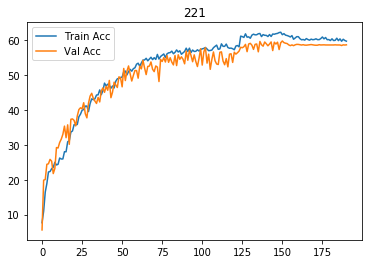

In [13]:
plt.title('221')
plt.plot(history221['acc'])
plt.plot(history221['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* * Best val Accuracy so far : 48.469 epoch : 85 *
* Hasn't learnt much why?

=====================================================

#### model 212


In [16]:
# model
torch.cuda.empty_cache()    
best_acc212 = 0
em_iters = [2,1,2]
model212 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history212={'val_acc':[],'acc':[]}
optimizer212 = optim.Adam(model212.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [2, 1, 2] 
stage output:  class_caps 
activation:  o


In [32]:
best_acc212= mainTrain('model212_A',epochs,model212,history212,optimizer212)
print('best test accuracy: {:.6f}'.format(best_acc212))

########### Training model model212_A ###########
Train Epoch: 1	[0/4575 (0%)]	Loss: 3.377066	Accuracy: 0.000000	
Train Epoch: 1	[800/4575 (17%)]	Loss: 2.006355	Accuracy: 0.000000	
Train Epoch: 1	[1600/4575 (35%)]	Loss: 1.801169	Accuracy: 9.375000	
Train Epoch: 1	[2400/4575 (52%)]	Loss: 1.197061	Accuracy: 21.875000	
Train Epoch: 1	[3200/4575 (70%)]	Loss: 1.447512	Accuracy: 18.750000	
Train Epoch: 1	[4000/4575 (87%)]	Loss: 0.756998	Accuracy: 43.750000	
Epoch Train-Accuracy : 19.0637
Test Completion: [------------------> ] 95%
Test set: Average loss: 36.032815, Accuracy: 32.134233 


saving model to belgium_weights\model_model212_A_1.pth
Current Learning Rate : 0.0029991244959936118
* Best val Accuracy so far : 32.134 epoch : 1 *
0 epochs with no improvement in val_acc.
Epoch time: 1.91 mins
Train Epoch: 2	[0/4575 (0%)]	Loss: 0.777782	Accuracy: 34.375000	
Train Epoch: 2	[800/4575 (17%)]	Loss: 1.035511	Accuracy: 25.000000	
Train Epoch: 2	[1600/4575 (35%)]	Loss: 0.899762	Accuracy: 25.00000

Train Epoch: 11	[0/4575 (0%)]	Loss: 0.095402	Accuracy: 90.625000	
Train Epoch: 11	[800/4575 (17%)]	Loss: 0.305762	Accuracy: 87.500000	
Train Epoch: 11	[1600/4575 (35%)]	Loss: 0.206778	Accuracy: 75.000000	
Train Epoch: 11	[2400/4575 (52%)]	Loss: 0.177736	Accuracy: 71.875000	
Train Epoch: 11	[3200/4575 (70%)]	Loss: 0.158733	Accuracy: 84.375000	
Train Epoch: 11	[4000/4575 (87%)]	Loss: 0.201522	Accuracy: 75.000000	
Epoch Train-Accuracy : 79.8916
Test Completion: [------------------> ] 95%
Test set: Average loss: 25.737533, Accuracy: 79.382102 


saving model to belgium_weights\model_model212_A_11.pth
Current Learning Rate : 0.002990383496266965
* Best val Accuracy so far : 79.382 epoch : 11 *
1 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 12	[0/4575 (0%)]	Loss: 0.120855	Accuracy: 93.750000	
Train Epoch: 12	[800/4575 (17%)]	Loss: 0.119205	Accuracy: 87.500000	
Train Epoch: 12	[1600/4575 (35%)]	Loss: 0.120700	Accuracy: 81.250000	
Train Epoch: 12	[2400/4575 (52%)]	

Train Epoch: 21	[0/4575 (0%)]	Loss: 0.099194	Accuracy: 87.500000	
Train Epoch: 21	[800/4575 (17%)]	Loss: 0.078868	Accuracy: 96.875000	
Train Epoch: 21	[1600/4575 (35%)]	Loss: 0.092213	Accuracy: 84.375000	
Train Epoch: 21	[2400/4575 (52%)]	Loss: 0.103335	Accuracy: 90.625000	
Train Epoch: 21	[3200/4575 (70%)]	Loss: 0.079472	Accuracy: 90.625000	
Train Epoch: 21	[4000/4575 (87%)]	Loss: 0.143361	Accuracy: 96.875000	
Epoch Train-Accuracy : 87.9568
Test Completion: [------------------> ] 95%
Test set: Average loss: 21.631141, Accuracy: 86.896307 


saving model to belgium_weights\model_model212_A_21.pth
Current Learning Rate : 0.0029816679723337785
* Best val Accuracy so far : 86.896 epoch : 21 *
3 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 22	[0/4575 (0%)]	Loss: 0.105095	Accuracy: 93.750000	
Train Epoch: 22	[800/4575 (17%)]	Loss: 0.148257	Accuracy: 81.250000	
Train Epoch: 22	[1600/4575 (35%)]	Loss: 0.116098	Accuracy: 90.625000	
Train Epoch: 22	[2400/4575 (52%)]

Train Epoch: 31	[0/4575 (0%)]	Loss: 0.084845	Accuracy: 93.750000	
Train Epoch: 31	[800/4575 (17%)]	Loss: 0.105163	Accuracy: 84.375000	
Train Epoch: 31	[1600/4575 (35%)]	Loss: 0.098919	Accuracy: 93.750000	
Train Epoch: 31	[2400/4575 (52%)]	Loss: 0.126960	Accuracy: 84.375000	
Train Epoch: 31	[3200/4575 (70%)]	Loss: 0.072659	Accuracy: 100.000000	
Train Epoch: 31	[4000/4575 (87%)]	Loss: 0.150332	Accuracy: 87.500000	
Epoch Train-Accuracy : 91.7585
Test Completion: [------------------> ] 95%
Test set: Average loss: 19.204870, Accuracy: 89.612926 


saving model to belgium_weights\model_model212_A_31.pth
Current Learning Rate : 0.0029729778499444155
* Best val Accuracy so far : 90.785 epoch : 30 *
1 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 32	[0/4575 (0%)]	Loss: 0.087207	Accuracy: 93.750000	
Train Epoch: 32	[800/4575 (17%)]	Loss: 0.111806	Accuracy: 93.750000	
Train Epoch: 32	[1600/4575 (35%)]	Loss: 0.076976	Accuracy: 96.875000	
Train Epoch: 32	[2400/4575 (52%)

Train Epoch: 41	[0/4575 (0%)]	Loss: 0.117491	Accuracy: 90.625000	
Train Epoch: 41	[800/4575 (17%)]	Loss: 0.087533	Accuracy: 90.625000	
Train Epoch: 41	[1600/4575 (35%)]	Loss: 0.187333	Accuracy: 93.750000	
Train Epoch: 41	[2400/4575 (52%)]	Loss: 0.067219	Accuracy: 100.000000	
Train Epoch: 41	[3200/4575 (70%)]	Loss: 0.128374	Accuracy: 90.625000	
Train Epoch: 41	[4000/4575 (87%)]	Loss: 0.148679	Accuracy: 81.250000	
Epoch Train-Accuracy : 93.0704
Test Completion: [------------------> ] 95%
Test set: Average loss: 16.536583, Accuracy: 92.091619 


saving model to belgium_weights\model_model212_A_41.pth
Current Learning Rate : 0.0029643130550656414
* Best val Accuracy so far : 92.092 epoch : 41 *
1 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 42	[0/4575 (0%)]	Loss: 0.078859	Accuracy: 93.750000	
Train Epoch: 42	[800/4575 (17%)]	Loss: 0.105574	Accuracy: 93.750000	
Train Epoch: 42	[1600/4575 (35%)]	Loss: 0.100252	Accuracy: 90.625000	
Train Epoch: 42	[2400/4575 (52%)

Train Epoch: 51	[0/4575 (0%)]	Loss: 0.115297	Accuracy: 96.875000	
Train Epoch: 51	[800/4575 (17%)]	Loss: 0.060086	Accuracy: 96.875000	
Train Epoch: 51	[1600/4575 (35%)]	Loss: 0.158988	Accuracy: 93.750000	
Train Epoch: 51	[2400/4575 (52%)]	Loss: 0.087318	Accuracy: 90.625000	
Train Epoch: 51	[3200/4575 (70%)]	Loss: 0.069222	Accuracy: 93.750000	
Train Epoch: 51	[4000/4575 (87%)]	Loss: 0.117508	Accuracy: 100.000000	
Epoch Train-Accuracy : 94.3168
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.594368, Accuracy: 91.995739 


saving model to belgium_weights\model_model212_A_51.pth
Current Learning Rate : 0.0029556735138799935
* Best val Accuracy so far : 93.381 epoch : 48 *
3 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 52	[0/4575 (0%)]	Loss: 0.107787	Accuracy: 96.875000	
Train Epoch: 52	[800/4575 (17%)]	Loss: 0.115271	Accuracy: 90.625000	
Train Epoch: 52	[1600/4575 (35%)]	Loss: 0.092146	Accuracy: 100.000000	
Train Epoch: 52	[2400/4575 (52%

Train Epoch: 61	[0/4575 (0%)]	Loss: 0.093422	Accuracy: 93.750000	
Train Epoch: 61	[800/4575 (17%)]	Loss: 0.125194	Accuracy: 96.875000	
Train Epoch: 61	[1600/4575 (35%)]	Loss: 0.081919	Accuracy: 96.875000	
Train Epoch: 61	[2400/4575 (52%)]	Loss: 0.101550	Accuracy: 100.000000	
Train Epoch: 61	[3200/4575 (70%)]	Loss: 0.072797	Accuracy: 90.625000	
Train Epoch: 61	[4000/4575 (87%)]	Loss: 0.058614	Accuracy: 100.000000	
Epoch Train-Accuracy : 95.5850
Test Completion: [------------------> ] 95%
Test set: Average loss: 14.334043, Accuracy: 93.263494 


saving model to belgium_weights\model_model212_A_61.pth
Current Learning Rate : 0.002947059152785149
* Best val Accuracy so far : 93.597 epoch : 57 *
4 epochs with no improvement in val_acc.
Epoch time: 1.91 mins
Train Epoch: 62	[0/4575 (0%)]	Loss: 0.109361	Accuracy: 87.500000	
Train Epoch: 62	[800/4575 (17%)]	Loss: 0.131886	Accuracy: 93.750000	
Train Epoch: 62	[1600/4575 (35%)]	Loss: 0.079140	Accuracy: 93.750000	
Train Epoch: 62	[2400/4575 (52%)

Train Epoch: 71	[0/4575 (0%)]	Loss: 0.095186	Accuracy: 100.000000	
Train Epoch: 71	[800/4575 (17%)]	Loss: 0.112531	Accuracy: 93.750000	
Train Epoch: 71	[1600/4575 (35%)]	Loss: 0.101454	Accuracy: 90.625000	
Train Epoch: 71	[2400/4575 (52%)]	Loss: 0.141819	Accuracy: 96.875000	
Train Epoch: 71	[3200/4575 (70%)]	Loss: 0.224593	Accuracy: 90.625000	
Train Epoch: 71	[4000/4575 (87%)]	Loss: 0.148824	Accuracy: 84.375000	
Epoch Train-Accuracy : 96.1101
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.701295, Accuracy: 92.677557 


saving model to belgium_weights\model_model212_A_71.pth
Current Learning Rate : 0.0029384698983933024
* Best val Accuracy so far : 94.553 epoch : 70 *
1 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 72	[0/4575 (0%)]	Loss: 0.181767	Accuracy: 90.625000	
Train Epoch: 72	[800/4575 (17%)]	Loss: 0.244492	Accuracy: 93.750000	
Train Epoch: 72	[1600/4575 (35%)]	Loss: 0.072809	Accuracy: 96.875000	
Train Epoch: 72	[2400/4575 (52%)

Train Epoch: 81	[0/4575 (0%)]	Loss: 0.113237	Accuracy: 96.875000	
Train Epoch: 81	[800/4575 (17%)]	Loss: 0.299088	Accuracy: 87.500000	
Train Epoch: 81	[1600/4575 (35%)]	Loss: 0.098101	Accuracy: 100.000000	
Train Epoch: 81	[2400/4575 (52%)]	Loss: 0.168408	Accuracy: 96.875000	
Train Epoch: 81	[3200/4575 (70%)]	Loss: 0.289208	Accuracy: 87.500000	
Train Epoch: 81	[4000/4575 (87%)]	Loss: 0.277918	Accuracy: 90.625000	
Epoch Train-Accuracy : 96.2187
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.892046, Accuracy: 93.302557 


saving model to belgium_weights\model_model212_A_81.pth
Current Learning Rate : 0.0029299056775305386
* Best val Accuracy so far : 94.943 epoch : 74 *
7 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 82	[0/4575 (0%)]	Loss: 0.149713	Accuracy: 93.750000	
Train Epoch: 82	[800/4575 (17%)]	Loss: 0.153155	Accuracy: 96.875000	
Train Epoch: 82	[1600/4575 (35%)]	Loss: 0.105379	Accuracy: 96.875000	
Train Epoch: 82	[2400/4575 (52%)

Train Epoch: 91	[0/4575 (0%)]	Loss: 0.194204	Accuracy: 96.875000	
Train Epoch: 91	[800/4575 (17%)]	Loss: 0.170364	Accuracy: 100.000000	
Train Epoch: 91	[1600/4575 (35%)]	Loss: 0.191543	Accuracy: 93.750000	
Train Epoch: 91	[2400/4575 (52%)]	Loss: 0.195899	Accuracy: 93.750000	
Train Epoch: 91	[3200/4575 (70%)]	Loss: 0.179353	Accuracy: 96.875000	
Train Epoch: 91	[4000/4575 (87%)]	Loss: 0.226406	Accuracy: 90.625000	
Epoch Train-Accuracy : 97.8802
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.179090, Accuracy: 94.708807 


saving model to belgium_weights\model_model212_A_91.pth
Current Learning Rate : 0.0002921366417236207
* Best val Accuracy so far : 94.943 epoch : 74 *
17 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 92	[0/4575 (0%)]	Loss: 0.184369	Accuracy: 100.000000	
Train Epoch: 92	[800/4575 (17%)]	Loss: 0.203080	Accuracy: 93.750000	
Train Epoch: 92	[1600/4575 (35%)]	Loss: 0.154926	Accuracy: 100.000000	
Train Epoch: 92	[2400/4575 (5

In [33]:
with open('model212_A_history.pkl','wb') as f:
    pickle.dump(history212,f)
torch.cuda.empty_cache()    

In [15]:
with open('belgium_weights_histories\\model122_history_length10.pkl','rb') as f:
    history122=pickle.load(f)

In [16]:
history122

{'val_acc': [37.95572910308838,
  49.50520820617676,
  56.53645820617676,
  66.10677070617676,
  64.21875,
  68.4765625,
  71.09375,
  72.60416660308837,
  78.984375]}

In [10]:
# with open('model212_A_history.pkl','rb') as f:
#     history212=pickle.load(f)

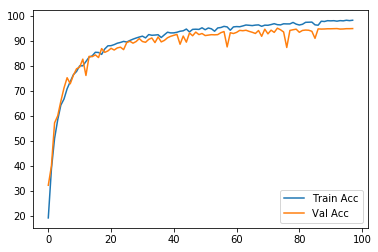

In [11]:
plt.plot(history212['acc'])
plt.plot(history212['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* * Best val Accuracy so far : 94.943 epoch : 74 *
* best accuracy among models
* better than the paper on facedatsets

=====================================================

#### model 2 3 2

In [17]:
# model
torch.cuda.empty_cache()
best_acc232 = 0
em_iters = [2,3,2]
model232 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history232={'val_acc':[],'acc':[]}
optimizer232 = optim.Adam(model232.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [2, 3, 2] 
stage output:  class_caps 
activation:  o


In [13]:
torch.cuda.empty_cache()

best_acc232= mainTrain('model232_A',epochs,model232,history232,optimizer232)
print('best test accuracy: {:.6f}'.format(best_acc232))

########### Training model model232_A ###########
Train Epoch: 1	[0/4575 (0%)]	Loss: 2.840281	Accuracy: 10.000000	
Train Epoch: 1	[750/4575 (16%)]	Loss: 1.628193	Accuracy: 3.333333	
Train Epoch: 1	[1500/4575 (33%)]	Loss: 1.411047	Accuracy: 23.333332	
Train Epoch: 1	[2250/4575 (49%)]	Loss: 1.012730	Accuracy: 13.333333	
Train Epoch: 1	[3000/4575 (65%)]	Loss: 1.267226	Accuracy: 16.666666	
Train Epoch: 1	[3750/4575 (82%)]	Loss: 1.027866	Accuracy: 20.000000	
Train Epoch: 1	[4500/4575 (98%)]	Loss: 1.773685	Accuracy: 10.000000	
Epoch Train-Accuracy : 16.0131
Test Completion: [------------------> ] 95%
Test set: Average loss: 40.087367, Accuracy: 19.545455 


saving model to belgium_weights\model_model232_A_1.pth
Current Learning Rate : 0.002999063281496468
* Best val Accuracy so far : 19.545 epoch : 1 *
0 epochs with no improvement in val_acc.
Epoch time: 2.62 mins
Train Epoch: 2	[0/4575 (0%)]	Loss: 1.208240	Accuracy: 33.333332	
Train Epoch: 2	[750/4575 (16%)]	Loss: 1.000621	Accuracy: 23.3333

Train Epoch: 10	[750/4575 (16%)]	Loss: 0.974183	Accuracy: 33.333332	
Train Epoch: 10	[1500/4575 (33%)]	Loss: 0.792967	Accuracy: 53.333332	
Train Epoch: 10	[2250/4575 (49%)]	Loss: 0.276094	Accuracy: 70.000000	
Train Epoch: 10	[3000/4575 (65%)]	Loss: 0.663428	Accuracy: 60.000000	
Train Epoch: 10	[3750/4575 (82%)]	Loss: 0.401144	Accuracy: 63.333332	
Train Epoch: 10	[4500/4575 (98%)]	Loss: 0.604806	Accuracy: 53.333332	
Epoch Train-Accuracy : 57.1895
Test Completion: [------------------> ] 95%
Test set: Average loss: 28.972571, Accuracy: 55.795454 


saving model to belgium_weights\model_model232_A_10.pth
Current Learning Rate : 0.0029906459656351097
* Best val Accuracy so far : 55.795 epoch : 10 *
2 epochs with no improvement in val_acc.
Epoch time: 2.66 mins
Train Epoch: 11	[0/4575 (0%)]	Loss: 0.625921	Accuracy: 60.000000	
Train Epoch: 11	[750/4575 (16%)]	Loss: 0.485016	Accuracy: 50.000000	
Train Epoch: 11	[1500/4575 (33%)]	Loss: 0.898406	Accuracy: 56.666664	
Train Epoch: 11	[2250/4575 (4

Train Epoch: 19	[750/4575 (16%)]	Loss: 0.087869	Accuracy: 93.333328	
Train Epoch: 19	[1500/4575 (33%)]	Loss: 0.367367	Accuracy: 53.333332	
Train Epoch: 19	[2250/4575 (49%)]	Loss: 0.396642	Accuracy: 66.666664	
Train Epoch: 19	[3000/4575 (65%)]	Loss: 0.343668	Accuracy: 66.666664	
Train Epoch: 19	[3750/4575 (82%)]	Loss: 0.265353	Accuracy: 83.333328	
Train Epoch: 19	[4500/4575 (98%)]	Loss: 0.378720	Accuracy: 56.666664	
Epoch Train-Accuracy : 72.5272
Test Completion: [------------------> ] 95%
Test set: Average loss: 21.728763, Accuracy: 75.220171 


saving model to belgium_weights\model_model232_A_19.pth
Current Learning Rate : 0.0029822522742190063
* Best val Accuracy so far : 75.220 epoch : 19 *
2 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 20	[0/4575 (0%)]	Loss: 0.122568	Accuracy: 86.666664	
Train Epoch: 20	[750/4575 (16%)]	Loss: 0.416625	Accuracy: 73.333328	
Train Epoch: 20	[1500/4575 (33%)]	Loss: 0.351214	Accuracy: 66.666664	
Train Epoch: 20	[2250/4575 (4

Train Epoch: 28	[750/4575 (16%)]	Loss: 0.345021	Accuracy: 70.000000	
Train Epoch: 28	[1500/4575 (33%)]	Loss: 0.138898	Accuracy: 76.666664	
Train Epoch: 28	[2250/4575 (49%)]	Loss: 0.246771	Accuracy: 76.666664	
Train Epoch: 28	[3000/4575 (65%)]	Loss: 0.511620	Accuracy: 73.333328	
Train Epoch: 28	[3750/4575 (82%)]	Loss: 0.216255	Accuracy: 70.000000	
Train Epoch: 28	[4500/4575 (98%)]	Loss: 0.460724	Accuracy: 73.333328	
Epoch Train-Accuracy : 79.8257
Test Completion: [------------------> ] 95%
Test set: Average loss: 19.712336, Accuracy: 74.009233 


saving model to belgium_weights\model_model232_A_28.pth
Current Learning Rate : 0.0029738821409426492
* Best val Accuracy so far : 76.083 epoch : 25 *
3 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 29	[0/4575 (0%)]	Loss: 0.230235	Accuracy: 73.333328	
Train Epoch: 29	[750/4575 (16%)]	Loss: 0.265408	Accuracy: 76.666664	
Train Epoch: 29	[1500/4575 (33%)]	Loss: 0.226930	Accuracy: 63.333332	
Train Epoch: 29	[2250/4575 (4

Train Epoch: 37	[750/4575 (16%)]	Loss: 0.183785	Accuracy: 86.666664	
Train Epoch: 37	[1500/4575 (33%)]	Loss: 0.447600	Accuracy: 83.333328	
Train Epoch: 37	[2250/4575 (49%)]	Loss: 0.200224	Accuracy: 80.000000	
Train Epoch: 37	[3000/4575 (65%)]	Loss: 0.128909	Accuracy: 90.000000	
Train Epoch: 37	[3750/4575 (82%)]	Loss: 0.182549	Accuracy: 90.000000	
Train Epoch: 37	[4500/4575 (98%)]	Loss: 0.249697	Accuracy: 83.333328	
Epoch Train-Accuracy : 81.9826
Test Completion: [------------------> ] 95%
Test set: Average loss: 17.802181, Accuracy: 78.913352 


saving model to belgium_weights\model_model232_A_37.pth
Current Learning Rate : 0.002965535499686625
* Best val Accuracy so far : 81.214 epoch : 34 *
3 epochs with no improvement in val_acc.
Epoch time: 2.64 mins
Train Epoch: 38	[0/4575 (0%)]	Loss: 0.210802	Accuracy: 80.000000	
Train Epoch: 38	[750/4575 (16%)]	Loss: 0.383776	Accuracy: 76.666664	
Train Epoch: 38	[1500/4575 (33%)]	Loss: 0.153693	Accuracy: 96.666664	
Train Epoch: 38	[2250/4575 (49

Train Epoch: 46	[750/4575 (16%)]	Loss: 0.159834	Accuracy: 100.000000	
Train Epoch: 46	[1500/4575 (33%)]	Loss: 0.382811	Accuracy: 86.666664	
Train Epoch: 46	[2250/4575 (49%)]	Loss: 0.301729	Accuracy: 86.666664	
Train Epoch: 46	[3000/4575 (65%)]	Loss: 0.147251	Accuracy: 90.000000	
Train Epoch: 46	[3750/4575 (82%)]	Loss: 0.258373	Accuracy: 83.333328	
Train Epoch: 46	[4500/4575 (98%)]	Loss: 0.260251	Accuracy: 70.000000	
Epoch Train-Accuracy : 83.8780
Test Completion: [------------------> ] 95%
Test set: Average loss: 16.874784, Accuracy: 78.845881 


saving model to belgium_weights\model_model232_A_46.pth
Current Learning Rate : 0.0029572122845170946
* Best val Accuracy so far : 83.050 epoch : 42 *
4 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 47	[0/4575 (0%)]	Loss: 0.147954	Accuracy: 93.333328	
Train Epoch: 47	[750/4575 (16%)]	Loss: 0.249215	Accuracy: 90.000000	
Train Epoch: 47	[1500/4575 (33%)]	Loss: 0.135479	Accuracy: 93.333328	
Train Epoch: 47	[2250/4575 (

Train Epoch: 55	[750/4575 (16%)]	Loss: 0.129301	Accuracy: 90.000000	
Train Epoch: 55	[1500/4575 (33%)]	Loss: 0.166848	Accuracy: 93.333328	
Train Epoch: 55	[2250/4575 (49%)]	Loss: 0.224294	Accuracy: 83.333328	
Train Epoch: 55	[3000/4575 (65%)]	Loss: 0.104011	Accuracy: 93.333328	
Train Epoch: 55	[3750/4575 (82%)]	Loss: 0.381386	Accuracy: 76.666664	
Train Epoch: 55	[4500/4575 (98%)]	Loss: 0.196949	Accuracy: 86.666664	
Epoch Train-Accuracy : 86.5795
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.835204, Accuracy: 81.544744 


saving model to belgium_weights\model_model232_A_55.pth
Current Learning Rate : 0.0029489124296852728
* Best val Accuracy so far : 86.023 epoch : 54 *
1 epochs with no improvement in val_acc.
Epoch time: 2.64 mins
Train Epoch: 56	[0/4575 (0%)]	Loss: 0.422370	Accuracy: 86.666664	
Train Epoch: 56	[750/4575 (16%)]	Loss: 0.150921	Accuracy: 86.666664	
Train Epoch: 56	[1500/4575 (33%)]	Loss: 0.164524	Accuracy: 90.000000	
Train Epoch: 56	[2250/4575 (4

Train Epoch: 64	[750/4575 (16%)]	Loss: 0.323948	Accuracy: 90.000000	
Train Epoch: 64	[1500/4575 (33%)]	Loss: 0.155556	Accuracy: 86.666664	
Train Epoch: 64	[2250/4575 (49%)]	Loss: 0.136756	Accuracy: 93.333328	
Train Epoch: 64	[3000/4575 (65%)]	Loss: 0.198819	Accuracy: 96.666664	
Train Epoch: 64	[3750/4575 (82%)]	Loss: 0.232630	Accuracy: 80.000000	
Train Epoch: 64	[4500/4575 (98%)]	Loss: 0.151433	Accuracy: 93.333328	
Epoch Train-Accuracy : 88.9542
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.270262, Accuracy: 82.237216 


saving model to belgium_weights\model_model232_A_64.pth
Current Learning Rate : 0.0029406358696269065
* Best val Accuracy so far : 86.101 epoch : 62 *
2 epochs with no improvement in val_acc.
Epoch time: 2.63 mins
Train Epoch: 65	[0/4575 (0%)]	Loss: 0.277490	Accuracy: 93.333328	
Train Epoch: 65	[750/4575 (16%)]	Loss: 0.220579	Accuracy: 83.333328	
Train Epoch: 65	[1500/4575 (33%)]	Loss: 0.188423	Accuracy: 86.666664	
Train Epoch: 65	[2250/4575 (4

Train Epoch: 73	[750/4575 (16%)]	Loss: 0.117333	Accuracy: 100.000000	
Train Epoch: 73	[1500/4575 (33%)]	Loss: 0.181376	Accuracy: 96.666664	
Train Epoch: 73	[2250/4575 (49%)]	Loss: 0.139981	Accuracy: 90.000000	
Train Epoch: 73	[3000/4575 (65%)]	Loss: 0.273500	Accuracy: 90.000000	
Train Epoch: 73	[3750/4575 (82%)]	Loss: 0.147579	Accuracy: 96.666664	
Train Epoch: 73	[4500/4575 (98%)]	Loss: 0.188511	Accuracy: 90.000000	
Epoch Train-Accuracy : 90.2396
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.953237, Accuracy: 85.245028 


saving model to belgium_weights\model_model232_A_73.pth
Current Learning Rate : 0.00293238253896176
* Best val Accuracy so far : 86.339 epoch : 68 *
5 epochs with no improvement in val_acc.
Epoch time: 2.64 mins
Train Epoch: 74	[0/4575 (0%)]	Loss: 0.190567	Accuracy: 90.000000	
Train Epoch: 74	[750/4575 (16%)]	Loss: 0.312873	Accuracy: 96.666664	
Train Epoch: 74	[1500/4575 (33%)]	Loss: 0.221389	Accuracy: 90.000000	
Train Epoch: 74	[2250/4575 (49

Train Epoch: 82	[750/4575 (16%)]	Loss: 0.221133	Accuracy: 93.333328	
Train Epoch: 82	[1500/4575 (33%)]	Loss: 0.264024	Accuracy: 90.000000	
Train Epoch: 82	[2250/4575 (49%)]	Loss: 0.204993	Accuracy: 96.666664	
Train Epoch: 82	[3000/4575 (65%)]	Loss: 0.519181	Accuracy: 93.333328	
Train Epoch: 82	[3750/4575 (82%)]	Loss: 0.308254	Accuracy: 86.666664	
Train Epoch: 82	[4500/4575 (98%)]	Loss: 0.532650	Accuracy: 80.000000	
Epoch Train-Accuracy : 90.4139
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.685046, Accuracy: 86.196733 


saving model to belgium_weights\model_model232_A_82.pth
Current Learning Rate : 0.002924152372493097
* Best val Accuracy so far : 87.528 epoch : 76 *
6 epochs with no improvement in val_acc.
Epoch time: 2.64 mins
Train Epoch: 83	[0/4575 (0%)]	Loss: 0.136203	Accuracy: 96.666664	
Train Epoch: 83	[750/4575 (16%)]	Loss: 0.162555	Accuracy: 90.000000	
Train Epoch: 83	[1500/4575 (33%)]	Loss: 0.184509	Accuracy: 93.333328	
Train Epoch: 83	[2250/4575 (49

Train Epoch: 91	[750/4575 (16%)]	Loss: 0.301207	Accuracy: 90.000000	
Train Epoch: 91	[1500/4575 (33%)]	Loss: 0.203196	Accuracy: 93.333328	
Train Epoch: 91	[2250/4575 (49%)]	Loss: 0.200958	Accuracy: 96.666664	
Train Epoch: 91	[3000/4575 (65%)]	Loss: 0.205580	Accuracy: 96.666664	
Train Epoch: 91	[3750/4575 (82%)]	Loss: 0.270646	Accuracy: 90.000000	
Train Epoch: 91	[4500/4575 (98%)]	Loss: 0.311220	Accuracy: 90.000000	
Epoch Train-Accuracy : 91.1547
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.067931, Accuracy: 86.470171 


saving model to belgium_weights\model_model232_A_91.pth
Current Learning Rate : 0.002915945305207163
* Best val Accuracy so far : 87.667 epoch : 86 *
5 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 92	[0/4575 (0%)]	Loss: 0.263135	Accuracy: 86.666664	
Train Epoch: 92	[750/4575 (16%)]	Loss: 0.569073	Accuracy: 93.333328	
Train Epoch: 92	[1500/4575 (33%)]	Loss: 0.936432	Accuracy: 90.000000	
Train Epoch: 92	[2250/4575 (49

Train Epoch: 100	[750/4575 (16%)]	Loss: 1.270932	Accuracy: 90.000000	
Train Epoch: 100	[1500/4575 (33%)]	Loss: 1.084057	Accuracy: 93.333328	
Train Epoch: 100	[2250/4575 (49%)]	Loss: 0.529621	Accuracy: 90.000000	
Train Epoch: 100	[3000/4575 (65%)]	Loss: 0.565803	Accuracy: 86.666664	
Train Epoch: 100	[3750/4575 (82%)]	Loss: 0.548244	Accuracy: 93.333328	
Train Epoch: 100	[4500/4575 (98%)]	Loss: 0.375143	Accuracy: 100.000000	
Epoch Train-Accuracy : 93.2244
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.570479, Accuracy: 88.345171 


saving model to belgium_weights\model_model232_A_100.pth
Current Learning Rate : 0.002907761272272678
* Best val Accuracy so far : 88.345 epoch : 100 *
1 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 101	[0/4575 (0%)]	Loss: 0.414714	Accuracy: 96.666664	
Train Epoch: 101	[750/4575 (16%)]	Loss: 0.505058	Accuracy: 96.666664	
Train Epoch: 101	[1500/4575 (33%)]	Loss: 0.616782	Accuracy: 90.000000	
Train Epoch: 101	[

Train Epoch: 109	[0/4575 (0%)]	Loss: 0.630375	Accuracy: 93.333328	
Train Epoch: 109	[750/4575 (16%)]	Loss: 1.024316	Accuracy: 86.666664	
Train Epoch: 109	[1500/4575 (33%)]	Loss: 0.871206	Accuracy: 86.666664	
Train Epoch: 109	[2250/4575 (49%)]	Loss: 0.698281	Accuracy: 86.666664	
Train Epoch: 109	[3000/4575 (65%)]	Loss: 0.656452	Accuracy: 100.000000	
Train Epoch: 109	[3750/4575 (82%)]	Loss: 0.733122	Accuracy: 83.333328	
Train Epoch: 109	[4500/4575 (98%)]	Loss: 0.749836	Accuracy: 90.000000	
Epoch Train-Accuracy : 91.9390
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.563865, Accuracy: 87.485796 


saving model to belgium_weights\model_model232_A_109.pth
Current Learning Rate : 0.0028996002090403176
* Best val Accuracy so far : 88.576 epoch : 102 *
7 epochs with no improvement in val_acc.
Epoch time: 2.60 mins
Train Epoch: 110	[0/4575 (0%)]	Loss: 1.055705	Accuracy: 90.000000	
Train Epoch: 110	[750/4575 (16%)]	Loss: 0.600533	Accuracy: 100.000000	
Train Epoch: 110	[15

Train Epoch: 118	[0/4575 (0%)]	Loss: 1.248256	Accuracy: 93.333328	
Train Epoch: 118	[750/4575 (16%)]	Loss: 0.971090	Accuracy: 93.333328	
Train Epoch: 118	[1500/4575 (33%)]	Loss: 1.034603	Accuracy: 96.666664	
Train Epoch: 118	[2250/4575 (49%)]	Loss: 1.108141	Accuracy: 86.666664	
Train Epoch: 118	[3000/4575 (65%)]	Loss: 1.067091	Accuracy: 93.333328	
Train Epoch: 118	[3750/4575 (82%)]	Loss: 1.037607	Accuracy: 100.000000	
Train Epoch: 118	[4500/4575 (98%)]	Loss: 1.130476	Accuracy: 86.666664	
Epoch Train-Accuracy : 92.8322
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.147082, Accuracy: 88.813921 


saving model to belgium_weights\model_model232_A_118.pth
Current Learning Rate : 0.002891462051042206
* Best val Accuracy so far : 88.839 epoch : 117 *
1 epochs with no improvement in val_acc.
Epoch time: 2.64 mins
Train Epoch: 119	[0/4575 (0%)]	Loss: 1.191176	Accuracy: 93.333328	
Train Epoch: 119	[750/4575 (16%)]	Loss: 1.125171	Accuracy: 86.666664	
Train Epoch: 119	[1500

Train Epoch: 127	[0/4575 (0%)]	Loss: 1.535325	Accuracy: 90.000000	
Train Epoch: 127	[750/4575 (16%)]	Loss: 1.589822	Accuracy: 90.000000	
Train Epoch: 127	[1500/4575 (33%)]	Loss: 1.399866	Accuracy: 93.333328	
Train Epoch: 127	[2250/4575 (49%)]	Loss: 1.473222	Accuracy: 96.666664	
Train Epoch: 127	[3000/4575 (65%)]	Loss: 1.412725	Accuracy: 93.333328	
Train Epoch: 127	[3750/4575 (82%)]	Loss: 2.124890	Accuracy: 93.333328	
Train Epoch: 127	[4500/4575 (98%)]	Loss: 1.478097	Accuracy: 96.666664	
Epoch Train-Accuracy : 93.3551
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.002747, Accuracy: 88.966619 


saving model to belgium_weights\model_model232_A_127.pth
Current Learning Rate : 0.0028833467339914073
* Best val Accuracy so far : 88.967 epoch : 127 *
10 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 128	[0/4575 (0%)]	Loss: 1.512830	Accuracy: 100.000000	
Train Epoch: 128	[750/4575 (16%)]	Loss: 1.408494	Accuracy: 96.666664	
Train Epoch: 128	[15

Train Epoch: 136	[0/4575 (0%)]	Loss: 1.897142	Accuracy: 96.666664	
Train Epoch: 136	[750/4575 (16%)]	Loss: 2.387377	Accuracy: 86.666664	
Train Epoch: 136	[1500/4575 (33%)]	Loss: 2.018827	Accuracy: 93.333328	
Train Epoch: 136	[2250/4575 (49%)]	Loss: 2.139399	Accuracy: 96.666664	
Train Epoch: 136	[3000/4575 (65%)]	Loss: 2.461180	Accuracy: 93.333328	
Train Epoch: 136	[3750/4575 (82%)]	Loss: 2.084771	Accuracy: 90.000000	
Train Epoch: 136	[4500/4575 (98%)]	Loss: 2.031119	Accuracy: 93.333328	
Epoch Train-Accuracy : 94.1830
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.825463, Accuracy: 89.357244 


saving model to belgium_weights\model_model232_A_136.pth
Current Learning Rate : 0.0028752541937814152
* Best val Accuracy so far : 89.357 epoch : 136 *
9 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 137	[0/4575 (0%)]	Loss: 2.069407	Accuracy: 96.666664	
Train Epoch: 137	[750/4575 (16%)]	Loss: 2.077727	Accuracy: 96.666664	
Train Epoch: 137	[1500

Train Epoch: 145	[0/4575 (0%)]	Loss: 2.871351	Accuracy: 93.333328	
Train Epoch: 145	[750/4575 (16%)]	Loss: 2.876028	Accuracy: 90.000000	
Train Epoch: 145	[1500/4575 (33%)]	Loss: 2.847854	Accuracy: 93.333328	
Train Epoch: 145	[2250/4575 (49%)]	Loss: 2.740221	Accuracy: 96.666664	
Train Epoch: 145	[3000/4575 (65%)]	Loss: 2.773633	Accuracy: 100.000000	
Train Epoch: 145	[3750/4575 (82%)]	Loss: 2.944783	Accuracy: 93.333328	
Train Epoch: 145	[4500/4575 (98%)]	Loss: 3.079654	Accuracy: 96.666664	
Epoch Train-Accuracy : 93.4205
Test Completion: [------------------> ] 95%
Test set: Average loss: 12.030192, Accuracy: 88.870739 


saving model to belgium_weights\model_model232_A_145.pth
Current Learning Rate : 0.0028671843664856483
* Best val Accuracy so far : 89.357 epoch : 136 *
9 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 146	[0/4575 (0%)]	Loss: 2.748015	Accuracy: 96.666664	
Train Epoch: 146	[750/4575 (16%)]	Loss: 3.002062	Accuracy: 90.000000	
Train Epoch: 146	[150

Train Epoch: 154	[0/4575 (0%)]	Loss: 3.274057	Accuracy: 100.000000	
Train Epoch: 154	[750/4575 (16%)]	Loss: 3.533277	Accuracy: 100.000000	
Train Epoch: 154	[1500/4575 (33%)]	Loss: 3.659091	Accuracy: 96.666664	
Train Epoch: 154	[2250/4575 (49%)]	Loss: 3.713237	Accuracy: 90.000000	
Train Epoch: 154	[3000/4575 (65%)]	Loss: 3.450488	Accuracy: 96.666664	
Train Epoch: 154	[3750/4575 (82%)]	Loss: 3.451938	Accuracy: 90.000000	
Train Epoch: 154	[4500/4575 (98%)]	Loss: 3.389814	Accuracy: 100.000000	
Epoch Train-Accuracy : 96.5142
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.472774, Accuracy: 90.745739 


saving model to belgium_weights\model_model232_A_154.pth
Current Learning Rate : 0.00028591371883569447
* Best val Accuracy so far : 90.746 epoch : 154 *
1 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 155	[0/4575 (0%)]	Loss: 3.482925	Accuracy: 96.666664	
Train Epoch: 155	[750/4575 (16%)]	Loss: 3.548123	Accuracy: 96.666664	
Train Epoch: 155	[

Train Epoch: 163	[0/4575 (0%)]	Loss: 4.350765	Accuracy: 100.000000	
Train Epoch: 163	[750/4575 (16%)]	Loss: 4.241745	Accuracy: 96.666664	
Train Epoch: 163	[1500/4575 (33%)]	Loss: 4.231331	Accuracy: 96.666664	
Train Epoch: 163	[2250/4575 (49%)]	Loss: 4.366530	Accuracy: 93.333328	
Train Epoch: 163	[3000/4575 (65%)]	Loss: 4.604512	Accuracy: 90.000000	
Train Epoch: 163	[3750/4575 (82%)]	Loss: 4.268392	Accuracy: 96.666664	
Train Epoch: 163	[4500/4575 (98%)]	Loss: 4.375128	Accuracy: 100.000000	
Epoch Train-Accuracy : 96.7538
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.386124, Accuracy: 90.724432 


saving model to belgium_weights\model_model232_A_163.pth
Current Learning Rate : 0.00028511125958270576
7 epochs with no improvement. Multiplying LR by 0.1
* Best val Accuracy so far : 90.902 epoch : 155 *
8 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 164	[0/4575 (0%)]	Loss: 4.665659	Accuracy: 90.000000	
Train Epoch: 164	[750/4575 (16%)]	Los

Train Epoch: 172	[0/4575 (0%)]	Loss: 5.546111	Accuracy: 93.333328	
Train Epoch: 172	[750/4575 (16%)]	Loss: 5.303077	Accuracy: 100.000000	
Train Epoch: 172	[1500/4575 (33%)]	Loss: 5.524545	Accuracy: 93.333328	
Train Epoch: 172	[2250/4575 (49%)]	Loss: 5.581554	Accuracy: 100.000000	
Train Epoch: 172	[3000/4575 (65%)]	Loss: 5.425385	Accuracy: 90.000000	
Train Epoch: 172	[3750/4575 (82%)]	Loss: 5.462348	Accuracy: 100.000000	
Train Epoch: 172	[4500/4575 (98%)]	Loss: 5.385427	Accuracy: 100.000000	
Epoch Train-Accuracy : 96.7974
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.436638, Accuracy: 90.901989 


saving model to belgium_weights\model_model232_A_172.pth
Current Learning Rate : 2.843110525506155e-06
* Best val Accuracy so far : 91.037 epoch : 166 *
6 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 173	[0/4575 (0%)]	Loss: 5.389963	Accuracy: 100.000000	
Train Epoch: 173	[750/4575 (16%)]	Loss: 5.644423	Accuracy: 96.666664	
Train Epoch: 173	

Train Epoch: 181	[0/4575 (0%)]	Loss: 6.614559	Accuracy: 96.666664	
Train Epoch: 181	[750/4575 (16%)]	Loss: 6.477495	Accuracy: 96.666664	
Train Epoch: 181	[1500/4575 (33%)]	Loss: 6.677027	Accuracy: 96.666664	
Train Epoch: 181	[2250/4575 (49%)]	Loss: 6.573976	Accuracy: 100.000000	
Train Epoch: 181	[3000/4575 (65%)]	Loss: 6.572968	Accuracy: 100.000000	
Train Epoch: 181	[3750/4575 (82%)]	Loss: 6.650527	Accuracy: 96.666664	
Train Epoch: 181	[4500/4575 (98%)]	Loss: 6.596381	Accuracy: 96.666664	
Epoch Train-Accuracy : 96.7974
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.412396, Accuracy: 90.901989 


saving model to belgium_weights\model_model232_A_181.pth
Current Learning Rate : 2.8351309141823173e-08
2 epochs with no improvement. Multiplying LR by 0.1
* Best val Accuracy so far : 91.037 epoch : 166 *
15 epochs with no improvement in val_acc.
Epoch time: 2.65 mins
Train Epoch: 182	[0/4575 (0%)]	Loss: 6.580527	Accuracy: 100.000000	
Train Epoch: 182	[750/4575 (16%)]	L

Train Epoch: 190	[0/4575 (0%)]	Loss: 7.703990	Accuracy: 100.000000	
Train Epoch: 190	[750/4575 (16%)]	Loss: 7.897972	Accuracy: 100.000000	
Train Epoch: 190	[1500/4575 (33%)]	Loss: 7.971156	Accuracy: 90.000000	
Train Epoch: 190	[2250/4575 (49%)]	Loss: 8.505593	Accuracy: 90.000000	
Train Epoch: 190	[3000/4575 (65%)]	Loss: 8.162124	Accuracy: 96.666664	
Train Epoch: 190	[3750/4575 (82%)]	Loss: 7.892263	Accuracy: 96.666664	
Train Epoch: 190	[4500/4575 (98%)]	Loss: 7.831200	Accuracy: 100.000000	
Epoch Train-Accuracy : 96.9499
Test Completion: [------------------> ] 95%
Test set: Average loss: 11.414337, Accuracy: 90.997869 


saving model to belgium_weights\model_model232_A_190.pth
Current Learning Rate : 2.8271736988210376e-11
2 epochs with no improvement. Multiplying LR by 0.1
* Best val Accuracy so far : 91.037 epoch : 166 *
24 epochs with no improvement in val_acc.
Model has converged. Existing the training.
best test accuracy: 91.036932


In [14]:
with open('model232_A_history.pkl','wb') as f:
    pickle.dump(history232,f)
torch.cuda.empty_cache()    

In [ ]:
plt.plot(history232['acc'])
plt.plot(history232['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

=====================================================

#### model 112

In [18]:
# model
torch.cuda.empty_cache()
best_acc112 = 0
em_iters = [1,1,2]
model112 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history112={'val_acc':[],'acc':[]}
optimizer112 = optim.Adam(model112.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [1, 1, 2] 
stage output:  class_caps 
activation:  o


In [31]:
torch.cuda.empty_cache()

best_acc112= mainTrain('model112_A',epochs,model112,history112,optimizer112)


########### Training model model112_A ###########
Train Epoch: 1	[0/4575 (0%)]	Loss: 3.749016	Accuracy: 0.000000	
Train Epoch: 1	[800/4575 (17%)]	Loss: 1.701563	Accuracy: 18.750000	
Train Epoch: 1	[1600/4575 (35%)]	Loss: 1.838649	Accuracy: 18.750000	
Train Epoch: 1	[2400/4575 (52%)]	Loss: 1.418447	Accuracy: 18.750000	
Train Epoch: 1	[3200/4575 (70%)]	Loss: 0.964500	Accuracy: 37.500000	
Train Epoch: 1	[4000/4575 (87%)]	Loss: 0.981084	Accuracy: 31.250000	
Epoch Train-Accuracy : 21.9695
Test Completion: [------------------> ] 95%
Test set: Average loss: 36.056810, Accuracy: 36.534091 


saving model to belgium_weights\model_model112_A_1.pth
Current Learning Rate : 0.0029991244959936118
* Best val Accuracy so far : 36.534 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 1.78 mins
Train Epoch: 2	[0/4575 (0%)]	Loss: 0.954862	Accuracy: 43.750000	
Train Epoch: 2	[800/4575 (17%)]	Loss: 0.622461	Accuracy: 40.625000	
Train Epoch: 2	[1600/4575 (35%)]	Loss: 0.697747	Accuracy: 

Train Epoch: 11	[0/4575 (0%)]	Loss: 0.201396	Accuracy: 78.125000	
Train Epoch: 11	[800/4575 (17%)]	Loss: 0.204848	Accuracy: 81.250000	
Train Epoch: 11	[1600/4575 (35%)]	Loss: 0.212965	Accuracy: 68.750000	
Train Epoch: 11	[2400/4575 (52%)]	Loss: 0.150294	Accuracy: 81.250000	
Train Epoch: 11	[3200/4575 (70%)]	Loss: 0.209956	Accuracy: 78.125000	
Train Epoch: 11	[4000/4575 (87%)]	Loss: 0.102692	Accuracy: 90.625000	
Epoch Train-Accuracy : 80.0410
Test Completion: [------------------> ] 95%
Test set: Average loss: 27.133631, Accuracy: 77.024148 


saving model to belgium_weights\model_model112_A_11.pth
Current Learning Rate : 0.002990383496266965
* Best val Accuracy so far : 80.217 epoch : 9 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.79 mins
Train Epoch: 12	[0/4575 (0%)]	Loss: 0.089656	Accuracy: 87.500000	
Train Epoch: 12	[800/4575 (17%)]	Loss: 0.232047	Accuracy: 75.000000	
Train Epoch: 12	[1600/4575 (35%)]	Loss: 0.233020	Accuracy: 84.375000	
Train Epoch: 12	[2400/4575 (5

Train Epoch: 21	[0/4575 (0%)]	Loss: 0.189226	Accuracy: 84.375000	
Train Epoch: 21	[800/4575 (17%)]	Loss: 0.096088	Accuracy: 84.375000	
Train Epoch: 21	[1600/4575 (35%)]	Loss: 0.094762	Accuracy: 96.875000	
Train Epoch: 21	[2400/4575 (52%)]	Loss: 0.129712	Accuracy: 93.750000	
Train Epoch: 21	[3200/4575 (70%)]	Loss: 0.127703	Accuracy: 87.500000	
Train Epoch: 21	[4000/4575 (87%)]	Loss: 0.192439	Accuracy: 81.250000	
Epoch Train-Accuracy : 87.3858
Test Completion: [------------------> ] 95%
Test set: Average loss: 23.037105, Accuracy: 85.355114 


saving model to belgium_weights\model_model112_A_21.pth
Current Learning Rate : 0.0029816679723337785
* Best val Accuracy so far : 87.287 epoch : 20 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 1.79 mins
Train Epoch: 22	[0/4575 (0%)]	Loss: 0.107463	Accuracy: 93.750000	
Train Epoch: 22	[800/4575 (17%)]	Loss: 0.167210	Accuracy: 87.500000	
Train Epoch: 22	[1600/4575 (35%)]	Loss: 0.123188	Accuracy: 84.375000	
Train Epoch: 22	[2400/4575 

Train Epoch: 31	[0/4575 (0%)]	Loss: 0.159320	Accuracy: 93.750000	
Train Epoch: 31	[800/4575 (17%)]	Loss: 0.120237	Accuracy: 87.500000	
Train Epoch: 31	[1600/4575 (35%)]	Loss: 0.144138	Accuracy: 81.250000	
Train Epoch: 31	[2400/4575 (52%)]	Loss: 0.166374	Accuracy: 84.375000	
Train Epoch: 31	[3200/4575 (70%)]	Loss: 0.168373	Accuracy: 84.375000	
Train Epoch: 31	[4000/4575 (87%)]	Loss: 0.109866	Accuracy: 100.000000	
Epoch Train-Accuracy : 90.7540
Test Completion: [------------------> ] 95%
Test set: Average loss: 20.296775, Accuracy: 88.107244 


saving model to belgium_weights\model_model112_A_31.pth
Current Learning Rate : 0.0029729778499444155
* Best val Accuracy so far : 90.295 epoch : 30 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 1.78 mins
Train Epoch: 32	[0/4575 (0%)]	Loss: 0.133115	Accuracy: 93.750000	
Train Epoch: 32	[800/4575 (17%)]	Loss: 0.105737	Accuracy: 90.625000	
Train Epoch: 32	[1600/4575 (35%)]	Loss: 0.172507	Accuracy: 81.250000	
Train Epoch: 32	[2400/4575

Train Epoch: 41	[0/4575 (0%)]	Loss: 0.136120	Accuracy: 96.875000	
Train Epoch: 41	[800/4575 (17%)]	Loss: 0.115588	Accuracy: 96.875000	
Train Epoch: 41	[1600/4575 (35%)]	Loss: 0.141927	Accuracy: 81.250000	
Train Epoch: 41	[2400/4575 (52%)]	Loss: 0.177444	Accuracy: 71.875000	
Train Epoch: 41	[3200/4575 (70%)]	Loss: 0.148623	Accuracy: 96.875000	
Train Epoch: 41	[4000/4575 (87%)]	Loss: 0.158317	Accuracy: 93.750000	
Epoch Train-Accuracy : 90.7336
Test Completion: [------------------> ] 95%
Test set: Average loss: 18.722750, Accuracy: 86.896307 


saving model to belgium_weights\model_model112_A_41.pth
Current Learning Rate : 0.0029643130550656414
* Best val Accuracy so far : 90.959 epoch : 39 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.79 mins
Train Epoch: 42	[0/4575 (0%)]	Loss: 0.248740	Accuracy: 93.750000	
Train Epoch: 42	[800/4575 (17%)]	Loss: 0.150741	Accuracy: 93.750000	
Train Epoch: 42	[1600/4575 (35%)]	Loss: 0.174393	Accuracy: 87.500000	
Train Epoch: 42	[2400/4575 

Train Epoch: 51	[0/4575 (0%)]	Loss: 0.077224	Accuracy: 100.000000	
Train Epoch: 51	[800/4575 (17%)]	Loss: 0.173564	Accuracy: 93.750000	
Train Epoch: 51	[1600/4575 (35%)]	Loss: 0.117899	Accuracy: 90.625000	
Train Epoch: 51	[2400/4575 (52%)]	Loss: 0.173978	Accuracy: 96.875000	
Train Epoch: 51	[3200/4575 (70%)]	Loss: 0.122771	Accuracy: 93.750000	
Train Epoch: 51	[4000/4575 (87%)]	Loss: 0.118278	Accuracy: 96.875000	
Epoch Train-Accuracy : 92.2619
Test Completion: [------------------> ] 95%
Test set: Average loss: 16.429544, Accuracy: 90.450994 


saving model to belgium_weights\model_model112_A_51.pth
Current Learning Rate : 0.0029556735138799935
* Best val Accuracy so far : 91.232 epoch : 47 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 1.78 mins
Train Epoch: 52	[0/4575 (0%)]	Loss: 0.122413	Accuracy: 93.750000	
Train Epoch: 52	[800/4575 (17%)]	Loss: 0.144304	Accuracy: 100.000000	
Train Epoch: 52	[1600/4575 (35%)]	Loss: 0.173573	Accuracy: 81.250000	
Train Epoch: 52	[2400/457

Train Epoch: 61	[0/4575 (0%)]	Loss: 0.138943	Accuracy: 100.000000	
Train Epoch: 61	[800/4575 (17%)]	Loss: 0.205754	Accuracy: 93.750000	
Train Epoch: 61	[1600/4575 (35%)]	Loss: 0.266088	Accuracy: 93.750000	
Train Epoch: 61	[2400/4575 (52%)]	Loss: 0.226706	Accuracy: 90.625000	
Train Epoch: 61	[3200/4575 (70%)]	Loss: 0.152611	Accuracy: 100.000000	
Train Epoch: 61	[4000/4575 (87%)]	Loss: 0.113561	Accuracy: 96.875000	
Epoch Train-Accuracy : 93.6844
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.741678, Accuracy: 91.331676 


saving model to belgium_weights\model_model112_A_61.pth
Current Learning Rate : 0.002947059152785149
* Best val Accuracy so far : 91.467 epoch : 58 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.78 mins
Train Epoch: 62	[0/4575 (0%)]	Loss: 0.084506	Accuracy: 100.000000	
Train Epoch: 62	[800/4575 (17%)]	Loss: 0.135404	Accuracy: 96.875000	
Train Epoch: 62	[1600/4575 (35%)]	Loss: 0.164202	Accuracy: 96.875000	
Train Epoch: 62	[2400/457

Train Epoch: 71	[0/4575 (0%)]	Loss: 0.171343	Accuracy: 100.000000	
Train Epoch: 71	[800/4575 (17%)]	Loss: 0.173130	Accuracy: 93.750000	
Train Epoch: 71	[1600/4575 (35%)]	Loss: 0.295032	Accuracy: 96.875000	
Train Epoch: 71	[2400/4575 (52%)]	Loss: 0.146937	Accuracy: 100.000000	
Train Epoch: 71	[3200/4575 (70%)]	Loss: 0.154668	Accuracy: 100.000000	
Train Epoch: 71	[4000/4575 (87%)]	Loss: 0.168765	Accuracy: 93.750000	
Epoch Train-Accuracy : 94.5797
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.502842, Accuracy: 89.573864 


saving model to belgium_weights\model_model112_A_71.pth
Current Learning Rate : 0.0029384698983933024
* Best val Accuracy so far : 91.740 epoch : 67 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 1.79 mins
Train Epoch: 72	[0/4575 (0%)]	Loss: 0.239629	Accuracy: 87.500000	
Train Epoch: 72	[800/4575 (17%)]	Loss: 0.246277	Accuracy: 93.750000	
Train Epoch: 72	[1600/4575 (35%)]	Loss: 0.165416	Accuracy: 90.625000	
Train Epoch: 72	[2400/45

Train Epoch: 81	[0/4575 (0%)]	Loss: 0.160307	Accuracy: 100.000000	
Train Epoch: 81	[800/4575 (17%)]	Loss: 0.350665	Accuracy: 90.625000	
Train Epoch: 81	[1600/4575 (35%)]	Loss: 0.283148	Accuracy: 96.875000	
Train Epoch: 81	[2400/4575 (52%)]	Loss: 0.250221	Accuracy: 93.750000	
Train Epoch: 81	[3200/4575 (70%)]	Loss: 0.180037	Accuracy: 96.875000	
Train Epoch: 81	[4000/4575 (87%)]	Loss: 0.199084	Accuracy: 96.875000	
Epoch Train-Accuracy : 94.6890
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.961059, Accuracy: 90.450994 


saving model to belgium_weights\model_model112_A_81.pth
Current Learning Rate : 0.0029299056775305386
* Best val Accuracy so far : 92.717 epoch : 72 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 1.78 mins
Train Epoch: 82	[0/4575 (0%)]	Loss: 0.420325	Accuracy: 87.500000	
Train Epoch: 82	[800/4575 (17%)]	Loss: 0.143309	Accuracy: 90.625000	
Train Epoch: 82	[1600/4575 (35%)]	Loss: 0.385544	Accuracy: 81.250000	
Train Epoch: 82	[2400/4575

best test accuracy: 92.716619


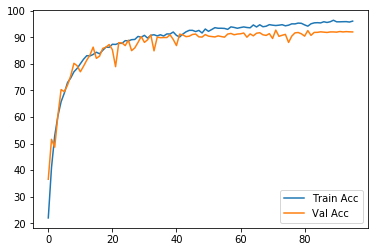

In [32]:
print('best test accuracy: {:.6f}'.format(best_acc112))
with open('model112_A_history.pkl','wb') as f:
    pickle.dump(history112,f)
torch.cuda.empty_cache()    

plt.plot(history112['acc'])
plt.plot(history112['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()


* Best val Accuracy so far : 92.717 epoch : 72 *


=====================================================

#### model 113

In [19]:
# model
torch.cuda.empty_cache()
best_acc113 = 0
em_iters = [1,1,3]
model113 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history113={'val_acc':[],'acc':[]}
optimizer113 = optim.Adam(model113.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [1, 1, 3] 
stage output:  class_caps 
activation:  o


In [34]:
torch.cuda.empty_cache()

best_acc113= mainTrain('model113_A',epochs,model113,history113,optimizer113)


########### Training model model113_A ###########
Train Epoch: 1	[0/4575 (0%)]	Loss: 4.134477	Accuracy: 6.250000	
Train Epoch: 1	[800/4575 (17%)]	Loss: 2.291200	Accuracy: 6.250000	
Train Epoch: 1	[1600/4575 (35%)]	Loss: 2.101180	Accuracy: 6.250000	
Train Epoch: 1	[2400/4575 (52%)]	Loss: 1.667086	Accuracy: 3.125000	
Train Epoch: 1	[3200/4575 (70%)]	Loss: 1.300999	Accuracy: 28.125000	
Train Epoch: 1	[4000/4575 (87%)]	Loss: 1.451826	Accuracy: 25.000000	
Epoch Train-Accuracy : 11.3030
Test Completion: [------------------> ] 95%
Test set: Average loss: 35.211420, Accuracy: 24.939631 


saving model to belgium_weights\model_model113_A_1.pth
Current Learning Rate : 0.0029991244959936118
* Best val Accuracy so far : 24.940 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 2	[0/4575 (0%)]	Loss: 0.748559	Accuracy: 28.125000	
Train Epoch: 2	[800/4575 (17%)]	Loss: 0.870962	Accuracy: 34.375000	
Train Epoch: 2	[1600/4575 (35%)]	Loss: 0.843500	Accuracy: 25.

Train Epoch: 11	[0/4575 (0%)]	Loss: 0.198927	Accuracy: 81.250000	
Train Epoch: 11	[800/4575 (17%)]	Loss: 0.205538	Accuracy: 84.375000	
Train Epoch: 11	[1600/4575 (35%)]	Loss: 0.217599	Accuracy: 87.500000	
Train Epoch: 11	[2400/4575 (52%)]	Loss: 0.273740	Accuracy: 71.875000	
Train Epoch: 11	[3200/4575 (70%)]	Loss: 0.220088	Accuracy: 71.875000	
Train Epoch: 11	[4000/4575 (87%)]	Loss: 0.147270	Accuracy: 81.250000	
Epoch Train-Accuracy : 80.0023
Test Completion: [------------------> ] 95%
Test set: Average loss: 26.765292, Accuracy: 78.110796 


saving model to belgium_weights\model_model113_A_11.pth
Current Learning Rate : 0.002990383496266965
* Best val Accuracy so far : 79.968 epoch : 10 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 1.92 mins
Train Epoch: 12	[0/4575 (0%)]	Loss: 0.140812	Accuracy: 84.375000	
Train Epoch: 12	[800/4575 (17%)]	Loss: 0.153174	Accuracy: 81.250000	
Train Epoch: 12	[1600/4575 (35%)]	Loss: 0.170970	Accuracy: 87.500000	
Train Epoch: 12	[2400/4575 (

Train Epoch: 21	[0/4575 (0%)]	Loss: 0.108643	Accuracy: 100.000000	
Train Epoch: 21	[800/4575 (17%)]	Loss: 0.171872	Accuracy: 96.875000	
Train Epoch: 21	[1600/4575 (35%)]	Loss: 0.222282	Accuracy: 81.250000	
Train Epoch: 21	[2400/4575 (52%)]	Loss: 0.165531	Accuracy: 78.125000	
Train Epoch: 21	[3200/4575 (70%)]	Loss: 0.129067	Accuracy: 96.875000	
Train Epoch: 21	[4000/4575 (87%)]	Loss: 0.169887	Accuracy: 75.000000	
Epoch Train-Accuracy : 86.4059
Test Completion: [------------------> ] 95%
Test set: Average loss: 23.730096, Accuracy: 83.906250 


saving model to belgium_weights\model_model113_A_21.pth
Current Learning Rate : 0.0029816679723337785
* Best val Accuracy so far : 83.906 epoch : 21 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 1.94 mins
Train Epoch: 22	[0/4575 (0%)]	Loss: 0.104597	Accuracy: 84.375000	
Train Epoch: 22	[800/4575 (17%)]	Loss: 0.143141	Accuracy: 93.750000	
Train Epoch: 22	[1600/4575 (35%)]	Loss: 0.095839	Accuracy: 87.500000	
Train Epoch: 22	[2400/4575

Train Epoch: 31	[0/4575 (0%)]	Loss: 0.139185	Accuracy: 90.625000	
Train Epoch: 31	[800/4575 (17%)]	Loss: 0.075018	Accuracy: 96.875000	
Train Epoch: 31	[1600/4575 (35%)]	Loss: 0.116919	Accuracy: 93.750000	
Train Epoch: 31	[2400/4575 (52%)]	Loss: 0.112024	Accuracy: 93.750000	
Train Epoch: 31	[3200/4575 (70%)]	Loss: 0.098295	Accuracy: 87.500000	
Train Epoch: 31	[4000/4575 (87%)]	Loss: 0.141084	Accuracy: 96.875000	
Epoch Train-Accuracy : 90.2965
Test Completion: [------------------> ] 95%
Test set: Average loss: 21.900924, Accuracy: 87.521307 


saving model to belgium_weights\model_model113_A_31.pth
Current Learning Rate : 0.0029729778499444155
* Best val Accuracy so far : 87.521 epoch : 31 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 1.95 mins
Train Epoch: 32	[0/4575 (0%)]	Loss: 0.116350	Accuracy: 90.625000	
Train Epoch: 32	[800/4575 (17%)]	Loss: 0.152870	Accuracy: 78.125000	
Train Epoch: 32	[1600/4575 (35%)]	Loss: 0.144453	Accuracy: 93.750000	
Train Epoch: 32	[2400/4575 

Train Epoch: 41	[0/4575 (0%)]	Loss: 0.103207	Accuracy: 90.625000	
Train Epoch: 41	[800/4575 (17%)]	Loss: 0.113127	Accuracy: 93.750000	
Train Epoch: 41	[1600/4575 (35%)]	Loss: 0.182591	Accuracy: 87.500000	
Train Epoch: 41	[2400/4575 (52%)]	Loss: 0.181049	Accuracy: 90.625000	
Train Epoch: 41	[3200/4575 (70%)]	Loss: 0.174245	Accuracy: 90.625000	
Train Epoch: 41	[4000/4575 (87%)]	Loss: 0.290136	Accuracy: 78.125000	
Epoch Train-Accuracy : 91.1678
Test Completion: [------------------> ] 95%
Test set: Average loss: 19.403175, Accuracy: 86.953125 


saving model to belgium_weights\model_model113_A_41.pth
Current Learning Rate : 0.0029643130550656414
* Best val Accuracy so far : 88.732 epoch : 39 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.95 mins
Train Epoch: 42	[0/4575 (0%)]	Loss: 0.101812	Accuracy: 93.750000	
Train Epoch: 42	[800/4575 (17%)]	Loss: 0.205112	Accuracy: 93.750000	
Train Epoch: 42	[1600/4575 (35%)]	Loss: 0.113926	Accuracy: 96.875000	
Train Epoch: 42	[2400/4575 

Train Epoch: 51	[0/4575 (0%)]	Loss: 0.225803	Accuracy: 87.500000	
Train Epoch: 51	[800/4575 (17%)]	Loss: 0.115833	Accuracy: 96.875000	
Train Epoch: 51	[1600/4575 (35%)]	Loss: 0.160462	Accuracy: 96.875000	
Train Epoch: 51	[2400/4575 (52%)]	Loss: 0.102912	Accuracy: 93.750000	
Train Epoch: 51	[3200/4575 (70%)]	Loss: 0.327776	Accuracy: 84.375000	
Train Epoch: 51	[4000/4575 (87%)]	Loss: 0.223658	Accuracy: 87.500000	
Epoch Train-Accuracy : 91.6274
Test Completion: [------------------> ] 95%
Test set: Average loss: 17.846816, Accuracy: 86.818182 


saving model to belgium_weights\model_model113_A_51.pth
Current Learning Rate : 0.0029556735138799935
* Best val Accuracy so far : 88.732 epoch : 39 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 1.94 mins
Train Epoch: 52	[0/4575 (0%)]	Loss: 0.175672	Accuracy: 90.625000	
Train Epoch: 52	[800/4575 (17%)]	Loss: 0.137167	Accuracy: 87.500000	
Train Epoch: 52	[1600/4575 (35%)]	Loss: 0.100976	Accuracy: 93.750000	
Train Epoch: 52	[2400/4575

Train Epoch: 61	[0/4575 (0%)]	Loss: 0.131333	Accuracy: 100.000000	
Train Epoch: 61	[800/4575 (17%)]	Loss: 0.093914	Accuracy: 100.000000	
Train Epoch: 61	[1600/4575 (35%)]	Loss: 0.413052	Accuracy: 93.750000	
Train Epoch: 61	[2400/4575 (52%)]	Loss: 0.108508	Accuracy: 93.750000	
Train Epoch: 61	[3200/4575 (70%)]	Loss: 0.182217	Accuracy: 93.750000	
Train Epoch: 61	[4000/4575 (87%)]	Loss: 0.157769	Accuracy: 84.375000	
Epoch Train-Accuracy : 93.4419
Test Completion: [------------------> ] 95%
Test set: Average loss: 16.489726, Accuracy: 88.458807 


saving model to belgium_weights\model_model113_A_61.pth
Current Learning Rate : 0.002947059152785149
* Best val Accuracy so far : 88.974 epoch : 52 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 1.95 mins
Train Epoch: 62	[0/4575 (0%)]	Loss: 0.177693	Accuracy: 93.750000	
Train Epoch: 62	[800/4575 (17%)]	Loss: 0.151457	Accuracy: 90.625000	
Train Epoch: 62	[1600/4575 (35%)]	Loss: 0.146831	Accuracy: 100.000000	
Train Epoch: 62	[2400/457

Train Epoch: 71	[0/4575 (0%)]	Loss: 0.175298	Accuracy: 90.625000	
Train Epoch: 71	[800/4575 (17%)]	Loss: 0.300718	Accuracy: 90.625000	
Train Epoch: 71	[1600/4575 (35%)]	Loss: 0.153387	Accuracy: 93.750000	
Train Epoch: 71	[2400/4575 (52%)]	Loss: 0.134107	Accuracy: 100.000000	
Train Epoch: 71	[3200/4575 (70%)]	Loss: 0.128859	Accuracy: 96.875000	
Train Epoch: 71	[4000/4575 (87%)]	Loss: 0.112878	Accuracy: 100.000000	
Epoch Train-Accuracy : 94.5142
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.617712, Accuracy: 87.940341 


saving model to belgium_weights\model_model113_A_71.pth
Current Learning Rate : 0.0029384698983933024
* Best val Accuracy so far : 89.925 epoch : 70 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 1.94 mins
Train Epoch: 72	[0/4575 (0%)]	Loss: 0.173150	Accuracy: 93.750000	
Train Epoch: 72	[800/4575 (17%)]	Loss: 0.111366	Accuracy: 96.875000	
Train Epoch: 72	[1600/4575 (35%)]	Loss: 0.175711	Accuracy: 87.500000	
Train Epoch: 72	[2400/457

Train Epoch: 81	[0/4575 (0%)]	Loss: 0.247058	Accuracy: 96.875000	
Train Epoch: 81	[800/4575 (17%)]	Loss: 0.179866	Accuracy: 96.875000	
Train Epoch: 81	[1600/4575 (35%)]	Loss: 0.268134	Accuracy: 96.875000	
Train Epoch: 81	[2400/4575 (52%)]	Loss: 0.237768	Accuracy: 93.750000	
Train Epoch: 81	[3200/4575 (70%)]	Loss: 0.341651	Accuracy: 93.750000	
Train Epoch: 81	[4000/4575 (87%)]	Loss: 0.226089	Accuracy: 93.750000	
Epoch Train-Accuracy : 95.3009
Test Completion: [------------------> ] 95%
Test set: Average loss: 14.962134, Accuracy: 88.362926 


saving model to belgium_weights\model_model113_A_81.pth
Current Learning Rate : 0.0029299056775305386
* Best val Accuracy so far : 89.925 epoch : 70 *
Total 11 epochs with no improvement in val_acc.
Epoch time: 1.95 mins
Train Epoch: 82	[0/4575 (0%)]	Loss: 0.366733	Accuracy: 81.250000	
Train Epoch: 82	[800/4575 (17%)]	Loss: 0.264545	Accuracy: 96.875000	
Train Epoch: 82	[1600/4575 (35%)]	Loss: 0.127410	Accuracy: 96.875000	
Train Epoch: 82	[2400/4575

Train Epoch: 100	[0/4575 (0%)]	Loss: 0.449704	Accuracy: 96.875000	
Train Epoch: 100	[800/4575 (17%)]	Loss: 0.509293	Accuracy: 100.000000	
Train Epoch: 100	[1600/4575 (35%)]	Loss: 0.384061	Accuracy: 100.000000	
Train Epoch: 100	[2400/4575 (52%)]	Loss: 0.487589	Accuracy: 100.000000	
Train Epoch: 100	[3200/4575 (70%)]	Loss: 0.612203	Accuracy: 96.875000	
Train Epoch: 100	[4000/4575 (87%)]	Loss: 0.423015	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.0664
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.992908, Accuracy: 90.003551 


saving model to belgium_weights\model_model113_A_100.pth
Current Learning Rate : 2.91370236412671e-06
* Best val Accuracy so far : 90.629 epoch : 85 *
Total 15 epochs with no improvement in val_acc.
Epoch time: 1.94 mins
Train Epoch: 101	[0/4575 (0%)]	Loss: 0.525586	Accuracy: 100.000000	
Train Epoch: 101	[800/4575 (17%)]	Loss: 0.581854	Accuracy: 96.875000	
Train Epoch: 101	[1600/4575 (35%)]	Loss: 0.513235	Accuracy: 96.875000	
Train Epoch: 

Train Epoch: 109	[3200/4575 (70%)]	Loss: 0.818526	Accuracy: 93.750000	
Train Epoch: 109	[4000/4575 (87%)]	Loss: 0.783358	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.1094
Test Completion: [------------------> ] 95%
Test set: Average loss: 14.008776, Accuracy: 90.003551 


saving model to belgium_weights\model_model113_A_109.pth
Current Learning Rate : 2.9060584172626048e-09
* Best val Accuracy so far : 90.629 epoch : 85 *
Total 24 epochs with no improvement in val_acc.
Model has converged. Existing the training.


best test accuracy: 90.628551


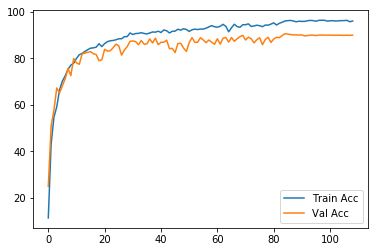

In [35]:
print('best test accuracy: {:.6f}'.format(best_acc113))
with open('model113_A_history.pkl','wb') as f:
    pickle.dump(history113,f)
torch.cuda.empty_cache()    

plt.plot(history113['acc'])
plt.plot(history113['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 90.629 epoch : 85 *


=====================================================

#### model 122

In [18]:
# model
torch.cuda.empty_cache()
best_acc122 = 0
em_iters = [1,2,2]
model122 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history122={'val_acc':[],'acc':[]}
optimizer122 = optim.Adam(model122.parameters(),
                          lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [1, 2, 2] 
stage output:  class_caps 
activation:  o


In [21]:
torch.cuda.empty_cache()
model122.load_state_dict(torch.load('belgium_weights\\model_model122_A_49.pth'))
best_acc122= mainTrain('model122_A',epochs,model122,history122,optimizer122,best_acc=89.24,best_epoch=48,previous_epochs=49)

########### Training model model122_A ###########
Train Epoch: 50	[0/4575 (0%)]	Loss: 0.069461	Accuracy: 90.625000	
Train Epoch: 50	[800/4575 (17%)]	Loss: 0.044491	Accuracy: 93.750000	
Train Epoch: 50	[1600/4575 (35%)]	Loss: 0.055365	Accuracy: 93.750000	
Train Epoch: 50	[2400/4575 (52%)]	Loss: 0.058298	Accuracy: 96.875000	
Train Epoch: 50	[3200/4575 (70%)]	Loss: 0.121959	Accuracy: 87.500000	
Train Epoch: 50	[4000/4575 (87%)]	Loss: 0.064339	Accuracy: 96.875000	
Epoch Train-Accuracy : 93.2241
Test Completion: [------------------> ] 95%
Test set: Average loss: 16.413925, Accuracy: 89.847301 


saving model to belgium_weights\model_model122_A_50.pth
Current Learning Rate : 0.002956536333681717
* Best val Accuracy so far : 89.847 epoch : 50 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 1.94 mins
Train Epoch: 51	[0/4575 (0%)]	Loss: 0.059404	Accuracy: 93.750000	
Train Epoch: 51	[800/4575 (17%)]	Loss: 0.082721	Accuracy: 90.625000	
Train Epoch: 51	[1600/4575 (35%)]	Loss: 0.074364

Train Epoch: 60	[0/4575 (0%)]	Loss: 0.081795	Accuracy: 90.625000	
Train Epoch: 60	[800/4575 (17%)]	Loss: 0.103128	Accuracy: 93.750000	
Train Epoch: 60	[1600/4575 (35%)]	Loss: 0.145503	Accuracy: 87.500000	
Train Epoch: 60	[2400/4575 (52%)]	Loss: 0.077528	Accuracy: 96.875000	
Train Epoch: 60	[3200/4575 (70%)]	Loss: 0.095692	Accuracy: 90.625000	
Train Epoch: 60	[4000/4575 (87%)]	Loss: 0.057084	Accuracy: 100.000000	
Epoch Train-Accuracy : 93.1797
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.242631, Accuracy: 90.532671 


saving model to belgium_weights\model_model122_A_60.pth
Current Learning Rate : 0.002947919457883778
* Best val Accuracy so far : 91.467 epoch : 55 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 1.95 mins
Train Epoch: 61	[0/4575 (0%)]	Loss: 0.074529	Accuracy: 93.750000	
Train Epoch: 61	[800/4575 (17%)]	Loss: 0.070415	Accuracy: 100.000000	
Train Epoch: 61	[1600/4575 (35%)]	Loss: 0.082736	Accuracy: 93.750000	
Train Epoch: 61	[2400/4575

Train Epoch: 70	[0/4575 (0%)]	Loss: 0.078664	Accuracy: 93.750000	
Train Epoch: 70	[800/4575 (17%)]	Loss: 0.202319	Accuracy: 93.750000	
Train Epoch: 70	[1600/4575 (35%)]	Loss: 0.042026	Accuracy: 100.000000	
Train Epoch: 70	[2400/4575 (52%)]	Loss: 0.037037	Accuracy: 100.000000	
Train Epoch: 70	[3200/4575 (70%)]	Loss: 0.086566	Accuracy: 100.000000	
Train Epoch: 70	[4000/4575 (87%)]	Loss: 0.113451	Accuracy: 87.500000	
Epoch Train-Accuracy : 94.7545
Test Completion: [------------------> ] 95%
Test set: Average loss: 14.578168, Accuracy: 91.700994 


saving model to belgium_weights\model_model122_A_70.pth
Current Learning Rate : 0.0029393276961179825
* Best val Accuracy so far : 91.935 epoch : 62 *
Total 8 epochs with no improvement in val_acc.
Epoch time: 1.94 mins
Train Epoch: 71	[0/4575 (0%)]	Loss: 0.101139	Accuracy: 96.875000	
Train Epoch: 71	[800/4575 (17%)]	Loss: 0.060538	Accuracy: 96.875000	
Train Epoch: 71	[1600/4575 (35%)]	Loss: 0.153873	Accuracy: 87.500000	
Train Epoch: 71	[2400/45

Train Epoch: 89	[1600/4575 (35%)]	Loss: 0.099055	Accuracy: 90.625000	
Train Epoch: 89	[2400/4575 (52%)]	Loss: 0.056357	Accuracy: 96.875000	
Train Epoch: 89	[3200/4575 (70%)]	Loss: 0.071915	Accuracy: 93.750000	
Train Epoch: 89	[4000/4575 (87%)]	Loss: 0.094143	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.2624
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.542939, Accuracy: 93.224432 


saving model to belgium_weights\model_model122_A_89.pth
Current Learning Rate : 0.00029230722759445604
* Best val Accuracy so far : 93.224 epoch : 89 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 1.95 mins
Train Epoch: 90	[0/4575 (0%)]	Loss: 0.079380	Accuracy: 96.875000	
Train Epoch: 90	[800/4575 (17%)]	Loss: 0.100973	Accuracy: 100.000000	
Train Epoch: 90	[1600/4575 (35%)]	Loss: 0.063328	Accuracy: 96.875000	
Train Epoch: 90	[2400/4575 (52%)]	Loss: 0.080113	Accuracy: 93.750000	
Train Epoch: 90	[3200/4575 (70%)]	Loss: 0.060669	Accuracy: 93.750000	
Train Epoch: 90	[400

Train Epoch: 99	[0/4575 (0%)]	Loss: 0.120429	Accuracy: 100.000000	
Train Epoch: 99	[800/4575 (17%)]	Loss: 0.063924	Accuracy: 96.875000	
Train Epoch: 99	[1600/4575 (35%)]	Loss: 0.137188	Accuracy: 100.000000	
Train Epoch: 99	[2400/4575 (52%)]	Loss: 0.086457	Accuracy: 93.750000	
Train Epoch: 99	[3200/4575 (70%)]	Loss: 0.095082	Accuracy: 93.750000	
Train Epoch: 99	[4000/4575 (87%)]	Loss: 0.094632	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.2850
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.332740, Accuracy: 92.911932 


saving model to belgium_weights\model_model122_A_99.pth
Current Learning Rate : 2.9145529317162258e-05
* Best val Accuracy so far : 93.224 epoch : 89 *
Total 10 epochs with no improvement in val_acc.
Epoch time: 1.94 mins
Train Epoch: 100	[0/4575 (0%)]	Loss: 0.203971	Accuracy: 96.875000	
Train Epoch: 100	[800/4575 (17%)]	Loss: 0.101917	Accuracy: 96.875000	
Train Epoch: 100	[1600/4575 (35%)]	Loss: 0.207163	Accuracy: 93.750000	
Train Epoch: 100	[24

Train Epoch: 108	[4000/4575 (87%)]	Loss: 0.132389	Accuracy: 100.000000	
Epoch Train-Accuracy : 96.0657
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.313264, Accuracy: 92.755682 


saving model to belgium_weights\model_model122_A_108.pth
Current Learning Rate : 2.906906753432214e-07
* Best val Accuracy so far : 93.224 epoch : 89 *
Total 19 epochs with no improvement in val_acc.
Epoch time: 1.95 mins
Train Epoch: 109	[0/4575 (0%)]	Loss: 0.173469	Accuracy: 90.625000	
Train Epoch: 109	[800/4575 (17%)]	Loss: 0.288537	Accuracy: 93.750000	
Train Epoch: 109	[1600/4575 (35%)]	Loss: 0.163331	Accuracy: 100.000000	
Train Epoch: 109	[2400/4575 (52%)]	Loss: 0.196923	Accuracy: 96.875000	
Train Epoch: 109	[3200/4575 (70%)]	Loss: 0.149256	Accuracy: 100.000000	
Train Epoch: 109	[4000/4575 (87%)]	Loss: 0.161982	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.4795
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.323359, Accuracy: 92.755682 


saving model to b

best test accuracy: 93.224432


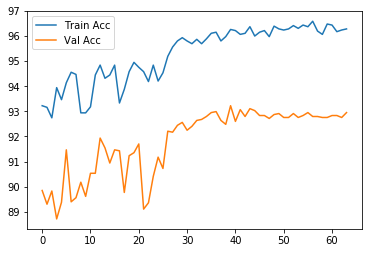

In [22]:
print('best test accuracy: {:.6f}'.format(best_acc122))
with open('model122_A_history.pkl','wb') as f:
    pickle.dump(history122,f)
torch.cuda.empty_cache()    

plt.plot(history122['acc'])
plt.plot(history122['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

In [17]:
model122.load_state_dict(torch.load('belgium_weights\\model_model122_A_10.pth'))
test(train_loader,model122,criterion,device)

Test Completion: [------------------->] 100%
Test set: Average loss: 26.720806, Accuracy: 78.034466 



78.03446553637097

#### model 123

In [21]:
# model
torch.cuda.empty_cache()
best_acc123 = 0
em_iters = [1,2,3]
model123 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history123={'val_acc':[],'acc':[]}
optimizer123 = optim.Adam(model123.parameters(), lr = init_lr, weight_decay = weight_decay)


model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 62, 3, 4] 
iters for routings:  [1, 2, 3] 
stage output:  class_caps 
activation:  o


In [24]:

torch.cuda.empty_cache()
# model123.load_state_dict(torch.load('belgium_weights\\model_model123_A_49.pth'))
best_acc123= mainTrain('model123_A',epochs,model123,history123,optimizer123)


########### Training model model123_A ###########
Train Epoch: 1	[0/4575 (0%)]	Loss: 3.701158	Accuracy: 0.000000	
Train Epoch: 1	[800/4575 (17%)]	Loss: 2.038944	Accuracy: 6.250000	
Train Epoch: 1	[1600/4575 (35%)]	Loss: 1.258614	Accuracy: 15.625000	
Train Epoch: 1	[2400/4575 (52%)]	Loss: 1.130090	Accuracy: 25.000000	
Train Epoch: 1	[3200/4575 (70%)]	Loss: 0.877943	Accuracy: 21.875000	
Train Epoch: 1	[4000/4575 (87%)]	Loss: 1.593435	Accuracy: 21.875000	
Epoch Train-Accuracy : 18.0585
Test Completion: [------------------> ] 95%
Test set: Average loss: 35.542587, Accuracy: 32.372159 


saving model to belgium_weights\model_model123_A_1.pth
Current Learning Rate : 0.0029991244959936118
* Best val Accuracy so far : 32.372 epoch : 1 *
Total 0 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 2	[0/4575 (0%)]	Loss: 1.461167	Accuracy: 15.625000	
Train Epoch: 2	[800/4575 (17%)]	Loss: 0.786069	Accuracy: 37.500000	
Train Epoch: 2	[1600/4575 (35%)]	Loss: 0.882498	Accuracy: 3

Train Epoch: 11	[0/4575 (0%)]	Loss: 0.261604	Accuracy: 65.625000	
Train Epoch: 11	[800/4575 (17%)]	Loss: 0.216026	Accuracy: 78.125000	
Train Epoch: 11	[1600/4575 (35%)]	Loss: 0.251619	Accuracy: 84.375000	
Train Epoch: 11	[2400/4575 (52%)]	Loss: 0.214662	Accuracy: 87.500000	
Train Epoch: 11	[3200/4575 (70%)]	Loss: 0.167883	Accuracy: 84.375000	
Train Epoch: 11	[4000/4575 (87%)]	Loss: 0.194427	Accuracy: 81.250000	
Epoch Train-Accuracy : 75.8706
Test Completion: [------------------> ] 95%
Test set: Average loss: 27.402547, Accuracy: 72.070312 


saving model to belgium_weights\model_model123_A_11.pth
Current Learning Rate : 0.002990383496266965
* Best val Accuracy so far : 72.070 epoch : 11 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 12	[0/4575 (0%)]	Loss: 0.150721	Accuracy: 81.250000	
Train Epoch: 12	[800/4575 (17%)]	Loss: 0.193639	Accuracy: 81.250000	
Train Epoch: 12	[1600/4575 (35%)]	Loss: 0.281705	Accuracy: 71.875000	
Train Epoch: 12	[2400/4575 (

Train Epoch: 21	[0/4575 (0%)]	Loss: 0.132791	Accuracy: 87.500000	
Train Epoch: 21	[800/4575 (17%)]	Loss: 0.346574	Accuracy: 75.000000	
Train Epoch: 21	[1600/4575 (35%)]	Loss: 0.215727	Accuracy: 68.750000	
Train Epoch: 21	[2400/4575 (52%)]	Loss: 0.162740	Accuracy: 84.375000	
Train Epoch: 21	[3200/4575 (70%)]	Loss: 0.239987	Accuracy: 75.000000	
Train Epoch: 21	[4000/4575 (87%)]	Loss: 0.233317	Accuracy: 75.000000	
Epoch Train-Accuracy : 84.1988
Test Completion: [------------------> ] 95%
Test set: Average loss: 23.722085, Accuracy: 80.664062 


saving model to belgium_weights\model_model123_A_21.pth
Current Learning Rate : 0.0029816679723337785
* Best val Accuracy so far : 80.664 epoch : 21 *
Total 3 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 22	[0/4575 (0%)]	Loss: 0.182214	Accuracy: 81.250000	
Train Epoch: 22	[800/4575 (17%)]	Loss: 0.142051	Accuracy: 81.250000	
Train Epoch: 22	[1600/4575 (35%)]	Loss: 0.220286	Accuracy: 84.375000	
Train Epoch: 22	[2400/4575 

Train Epoch: 31	[0/4575 (0%)]	Loss: 0.191252	Accuracy: 84.375000	
Train Epoch: 31	[800/4575 (17%)]	Loss: 0.338745	Accuracy: 87.500000	
Train Epoch: 31	[1600/4575 (35%)]	Loss: 0.150204	Accuracy: 90.625000	
Train Epoch: 31	[2400/4575 (52%)]	Loss: 0.206368	Accuracy: 90.625000	
Train Epoch: 31	[3200/4575 (70%)]	Loss: 0.118655	Accuracy: 84.375000	
Train Epoch: 31	[4000/4575 (87%)]	Loss: 0.212734	Accuracy: 90.625000	
Epoch Train-Accuracy : 88.3495
Test Completion: [------------------> ] 95%
Test set: Average loss: 21.719381, Accuracy: 83.366477 


saving model to belgium_weights\model_model123_A_31.pth
Current Learning Rate : 0.0029729778499444155
* Best val Accuracy so far : 84.031 epoch : 27 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 32	[0/4575 (0%)]	Loss: 0.171123	Accuracy: 87.500000	
Train Epoch: 32	[800/4575 (17%)]	Loss: 0.298163	Accuracy: 90.625000	
Train Epoch: 32	[1600/4575 (35%)]	Loss: 0.261678	Accuracy: 81.250000	
Train Epoch: 32	[2400/4575 

Train Epoch: 41	[0/4575 (0%)]	Loss: 0.206834	Accuracy: 93.750000	
Train Epoch: 41	[800/4575 (17%)]	Loss: 0.191370	Accuracy: 87.500000	
Train Epoch: 41	[1600/4575 (35%)]	Loss: 0.316202	Accuracy: 84.375000	
Train Epoch: 41	[2400/4575 (52%)]	Loss: 0.203673	Accuracy: 96.875000	
Train Epoch: 41	[3200/4575 (70%)]	Loss: 0.125394	Accuracy: 93.750000	
Train Epoch: 41	[4000/4575 (87%)]	Loss: 0.157761	Accuracy: 93.750000	
Epoch Train-Accuracy : 90.6884
Test Completion: [------------------> ] 95%
Test set: Average loss: 19.426882, Accuracy: 87.070312 


saving model to belgium_weights\model_model123_A_41.pth
Current Learning Rate : 0.0029643130550656414
* Best val Accuracy so far : 87.070 epoch : 41 *
Total 1 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 42	[0/4575 (0%)]	Loss: 0.154397	Accuracy: 96.875000	
Train Epoch: 42	[800/4575 (17%)]	Loss: 0.105877	Accuracy: 100.000000	
Train Epoch: 42	[1600/4575 (35%)]	Loss: 0.142215	Accuracy: 96.875000	
Train Epoch: 42	[2400/4575

Train Epoch: 51	[0/4575 (0%)]	Loss: 0.145803	Accuracy: 93.750000	
Train Epoch: 51	[800/4575 (17%)]	Loss: 0.161303	Accuracy: 93.750000	
Train Epoch: 51	[1600/4575 (35%)]	Loss: 0.205693	Accuracy: 90.625000	
Train Epoch: 51	[2400/4575 (52%)]	Loss: 0.188847	Accuracy: 96.875000	
Train Epoch: 51	[3200/4575 (70%)]	Loss: 0.144355	Accuracy: 93.750000	
Train Epoch: 51	[4000/4575 (87%)]	Loss: 0.132766	Accuracy: 93.750000	
Epoch Train-Accuracy : 90.9091
Test Completion: [------------------> ] 95%
Test set: Average loss: 17.633233, Accuracy: 88.068182 


saving model to belgium_weights\model_model123_A_51.pth
Current Learning Rate : 0.0029556735138799935
* Best val Accuracy so far : 88.068 epoch : 51 *
Total 5 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 52	[0/4575 (0%)]	Loss: 0.154056	Accuracy: 90.625000	
Train Epoch: 52	[800/4575 (17%)]	Loss: 0.168890	Accuracy: 87.500000	
Train Epoch: 52	[1600/4575 (35%)]	Loss: 0.299407	Accuracy: 81.250000	
Train Epoch: 52	[2400/4575 

Train Epoch: 61	[0/4575 (0%)]	Loss: 0.182288	Accuracy: 90.625000	
Train Epoch: 61	[800/4575 (17%)]	Loss: 0.200319	Accuracy: 81.250000	
Train Epoch: 61	[1600/4575 (35%)]	Loss: 0.112116	Accuracy: 96.875000	
Train Epoch: 61	[2400/4575 (52%)]	Loss: 0.231999	Accuracy: 90.625000	
Train Epoch: 61	[3200/4575 (70%)]	Loss: 0.183230	Accuracy: 96.875000	
Train Epoch: 61	[4000/4575 (87%)]	Loss: 0.129217	Accuracy: 93.750000	
Epoch Train-Accuracy : 92.3063
Test Completion: [------------------> ] 95%
Test set: Average loss: 16.866132, Accuracy: 87.095171 


saving model to belgium_weights\model_model123_A_61.pth
Current Learning Rate : 0.002947059152785149
* Best val Accuracy so far : 88.910 epoch : 59 *
Total 2 epochs with no improvement in val_acc.
Epoch time: 2.07 mins
Train Epoch: 62	[0/4575 (0%)]	Loss: 0.462609	Accuracy: 93.750000	
Train Epoch: 62	[800/4575 (17%)]	Loss: 0.324189	Accuracy: 84.375000	
Train Epoch: 62	[1600/4575 (35%)]	Loss: 0.187122	Accuracy: 93.750000	
Train Epoch: 62	[2400/4575 (

Train Epoch: 71	[0/4575 (0%)]	Loss: 0.392413	Accuracy: 90.625000	
Train Epoch: 71	[800/4575 (17%)]	Loss: 0.193957	Accuracy: 90.625000	
Train Epoch: 71	[1600/4575 (35%)]	Loss: 0.132794	Accuracy: 93.750000	
Train Epoch: 71	[2400/4575 (52%)]	Loss: 0.916105	Accuracy: 87.500000	
Train Epoch: 71	[3200/4575 (70%)]	Loss: 0.210202	Accuracy: 93.750000	
Train Epoch: 71	[4000/4575 (87%)]	Loss: 0.218457	Accuracy: 100.000000	
Epoch Train-Accuracy : 93.1586
Test Completion: [------------------> ] 95%
Test set: Average loss: 15.485884, Accuracy: 89.477983 


saving model to belgium_weights\model_model123_A_71.pth
Current Learning Rate : 0.0029384698983933024
* Best val Accuracy so far : 89.478 epoch : 71 *
Total 12 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 72	[0/4575 (0%)]	Loss: 0.241740	Accuracy: 93.750000	
Train Epoch: 72	[800/4575 (17%)]	Loss: 0.164880	Accuracy: 93.750000	
Train Epoch: 72	[1600/4575 (35%)]	Loss: 0.202048	Accuracy: 90.625000	
Train Epoch: 72	[2400/457

Train Epoch: 81	[0/4575 (0%)]	Loss: 0.263214	Accuracy: 93.750000	
Train Epoch: 81	[800/4575 (17%)]	Loss: 0.267095	Accuracy: 90.625000	
Train Epoch: 81	[1600/4575 (35%)]	Loss: 0.367003	Accuracy: 93.750000	
Train Epoch: 81	[2400/4575 (52%)]	Loss: 0.268831	Accuracy: 100.000000	
Train Epoch: 81	[3200/4575 (70%)]	Loss: 0.257355	Accuracy: 93.750000	
Train Epoch: 81	[4000/4575 (87%)]	Loss: 0.255991	Accuracy: 93.750000	
Epoch Train-Accuracy : 93.6400
Test Completion: [------------------> ] 95%
Test set: Average loss: 14.487030, Accuracy: 88.515625 


saving model to belgium_weights\model_model123_A_81.pth
Current Learning Rate : 0.0029299056775305386
* Best val Accuracy so far : 89.748 epoch : 72 *
Total 9 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 82	[0/4575 (0%)]	Loss: 0.406463	Accuracy: 96.875000	
Train Epoch: 82	[800/4575 (17%)]	Loss: 0.673159	Accuracy: 93.750000	
Train Epoch: 82	[1600/4575 (35%)]	Loss: 0.195459	Accuracy: 100.000000	
Train Epoch: 82	[2400/457

Train Epoch: 100	[1600/4575 (35%)]	Loss: 0.377582	Accuracy: 96.875000	
Train Epoch: 100	[2400/4575 (52%)]	Loss: 0.446499	Accuracy: 93.750000	
Train Epoch: 100	[3200/4575 (70%)]	Loss: 0.432807	Accuracy: 96.875000	
Train Epoch: 100	[4000/4575 (87%)]	Loss: 0.534373	Accuracy: 90.625000	
Epoch Train-Accuracy : 96.2398
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.626005, Accuracy: 90.099432 


saving model to belgium_weights\model_model123_A_100.pth
Current Learning Rate : 0.00029137023641267096
* Best val Accuracy so far : 90.451 epoch : 96 *
Total 4 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 101	[0/4575 (0%)]	Loss: 0.431233	Accuracy: 96.875000	
Train Epoch: 101	[800/4575 (17%)]	Loss: 0.627598	Accuracy: 84.375000	
Train Epoch: 101	[1600/4575 (35%)]	Loss: 0.556185	Accuracy: 96.875000	
Train Epoch: 101	[2400/4575 (52%)]	Loss: 0.509743	Accuracy: 96.875000	
Train Epoch: 101	[3200/4575 (70%)]	Loss: 0.372917	Accuracy: 100.000000	
Train Epoc

Train Epoch: 110	[0/4575 (0%)]	Loss: 0.912565	Accuracy: 93.750000	
Train Epoch: 110	[800/4575 (17%)]	Loss: 0.809131	Accuracy: 96.875000	
Train Epoch: 110	[1600/4575 (35%)]	Loss: 0.749109	Accuracy: 96.875000	
Train Epoch: 110	[2400/4575 (52%)]	Loss: 0.817634	Accuracy: 87.500000	
Train Epoch: 110	[3200/4575 (70%)]	Loss: 0.702477	Accuracy: 100.000000	
Train Epoch: 110	[4000/4575 (87%)]	Loss: 0.939674	Accuracy: 100.000000	
Epoch Train-Accuracy : 95.8691
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.606612, Accuracy: 89.417614 


saving model to belgium_weights\model_model123_A_110.pth
Current Learning Rate : 2.9052103286669003e-06
* Best val Accuracy so far : 90.451 epoch : 96 *
Total 14 epochs with no improvement in val_acc.
Epoch time: 2.09 mins
Train Epoch: 111	[0/4575 (0%)]	Loss: 0.748261	Accuracy: 96.875000	
Train Epoch: 111	[800/4575 (17%)]	Loss: 0.728843	Accuracy: 96.875000	
Train Epoch: 111	[1600/4575 (35%)]	Loss: 0.743363	Accuracy: 100.000000	
Train Epoch:

Train Epoch: 119	[4000/4575 (87%)]	Loss: 1.291620	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.2413
Test Completion: [------------------> ] 95%
Test set: Average loss: 13.598674, Accuracy: 89.378551 


saving model to belgium_weights\model_model123_A_119.pth
Current Learning Rate : 2.8975886602168925e-08
2 epochs with no improvement since the multiplication. Multiplying LR by 0.1
* Best val Accuracy so far : 90.451 epoch : 96 *
Total 23 epochs with no improvement in val_acc.
Epoch time: 2.08 mins
Train Epoch: 120	[0/4575 (0%)]	Loss: 1.264416	Accuracy: 90.625000	
Train Epoch: 120	[800/4575 (17%)]	Loss: 1.227455	Accuracy: 93.750000	
Train Epoch: 120	[1600/4575 (35%)]	Loss: 1.301487	Accuracy: 96.875000	
Train Epoch: 120	[2400/4575 (52%)]	Loss: 1.238342	Accuracy: 100.000000	
Train Epoch: 120	[3200/4575 (70%)]	Loss: 1.455223	Accuracy: 96.875000	
Train Epoch: 120	[4000/4575 (87%)]	Loss: 1.446938	Accuracy: 96.875000	
Epoch Train-Accuracy : 96.2413
Test Completion: [------------------> ] 95%

best test accuracy: 90.450994


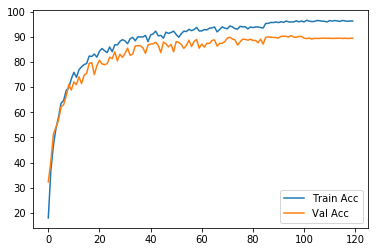

In [25]:

print('best test accuracy: {:.6f}'.format(best_acc123))
with open('model123_A_history.pkl','wb') as f:
    pickle.dump(history123,f)
torch.cuda.empty_cache()    

plt.plot(history123['acc'])
plt.plot(history123['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 90.451 epoch : 96 *
